# ___Problem Statement___
## _Business Problem Overview_
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

# ___Importing key libraries___

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import re
import os

import missingno as msno

from sklearn.model_selection import train_test_split # Train Test Split 
from sklearn.experimental import enable_iterative_imputer  # Needed to enable IterativeImputer
from sklearn.impute import IterativeImputer # For Imputing Null Values 
from sklearn.linear_model import LogisticRegression # Initial Model
from sklearn.preprocessing import MinMaxScaler # Scaling the Data
from sklearn.ensemble import RandomForestClassifier # Finding the Important Features
from sklearn.tree import DecisionTreeClassifier  # Base estimator for AdaBoost
from sklearn.ensemble import AdaBoostClassifier # AdaBoost Classifier
from sklearn.decomposition import PCA # Principal Component Analysis
from sklearn.decomposition import IncrementalPCA # `Incremental PCA` is useful for large datasets
from imblearn.pipeline import Pipeline # `Pipeline` is useful for chaining the operations
from sklearn.model_selection import GridSearchCV, KFold # Grid Search CV
from imblearn.over_sampling import SMOTE # `SMOTE` is used for Oversampling
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score 
# `metrics` are used for evaluation

import matplotlib as mpl # For customizing the colors
import matplotlib.pyplot as plt # For Plots

import statsmodels.api as sm # For finding the p-values

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input/telecom-churn-datasets'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# We can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# We can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### ___Assiging the Dataset to the .csv files___

In [3]:
# Using Pandas to Load and Read the Data
data_dictionary = pd.read_csv('data_dictionary.csv')
test_df = pd.read_csv('train.csv')
unseen_df = pd.read_csv('test.csv')

In [4]:
# Displaying the size and shape of the data
print(data_dictionary.shape)
print(test_df.shape)
print(unseen_df.shape)

(36, 2)
(69999, 172)
(30000, 171)


# ___Understanding the data___

In [ ]:
# Displaying the dictionary to understnad the data better 
data_dictionary

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [6]:
test_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [7]:
test_df.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [8]:
unseen_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [9]:
print(test_df.columns)

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)


# ___Generating new coulumns___
___Consider the data acroms and finding the most sutaible combination___

In [10]:
# Identifying key variables based on descriptions
ids = ['id', 'circle_id']

# Adding revenue and amount-related variables
total_amounts = [i for i in list(test_df.columns) if re.search('total.+amt', i)]
recharge_amounts = [i for i in list(test_df.columns) if re.search('rech.+amt', i)]
vbc_costs = [i for i in list(test_df.columns) if re.search('vbc', i)]
arpu_values = [i for i in list(test_df.columns) if re.search('arpu', i)]

# Call usage variables
total_outgoing_minutes = [i for i in list(test_df.columns) if re.search('total.+og.+mou', i)]
incoming_minutes = [i for i in list(test_df.columns) if re.search('ic.+mou', i)]
roaming_minutes = [i for i in list(test_df.columns) if re.search('roam.+mou', i)]
special_call_minutes = [i for i in list(test_df.columns) if re.search('spl.+mou', i)]
isd_call_minutes = [i for i in list(test_df.columns) if re.search('isd.+mou', i)]

# On-net and off-net variables
onnet_minutes = [i for i in list(test_df.columns) if re.search('onnet.+mou', i)]
offnetwork_minutes = [i for i in list(test_df.columns) if re.search('offnet.+mou', i)]

# Internet usage variables
volume_3g = [i for i in list(test_df.columns) if re.search('vol.+3g', i)]
volume_2g = [i for i in list(test_df.columns) if re.search('vol.+2g', i)]
average_revenue_3g = [i for i in list(test_df.columns) if re.search('arpu.+3g', i)]
average_revenue_2g = [i for i in list(test_df.columns) if re.search('arpu.+2g', i)]

# Age and scheme-related variables
age_on_network = [i for i in list(test_df.columns) if re.search('aon', i)]
night_usage = [i for i in list(test_df.columns) if re.search('night', i)]
monthly_schemes = [i for i in list(test_df.columns) if re.search('monthly', i)]
sachet_schemes = [i for i in list(test_df.columns) if re.search('sachet', i)]
fb_user = [i for i in list(test_df.columns) if re.search('fb_user', i)]

# Call type-specific usage
t2t_calls = [i for i in list(test_df.columns) if re.search('t2t', i)]
t2m_calls = [i for i in list(test_df.columns) if re.search('t2m', i)]
t2o_calls = [i for i in list(test_df.columns) if re.search('t2o', i)]
t2f_calls = [i for i in list(test_df.columns) if re.search('t2f', i)]
t2c_calls = [i for i in list(test_df.columns) if re.search('t2c', i)]

# KPIs for specific months
monthly_kpis = [i for i in list(test_df.columns) if re.search(r'\.\d+', i)]

# Storing them in a single flat list
variables = [
    *ids,
    *total_amounts,
    *recharge_amounts,
    *vbc_costs,
    *arpu_values,
    *total_outgoing_minutes,
    *incoming_minutes,
    *roaming_minutes,
    *special_call_minutes,
    *isd_call_minutes,
    *onnet_minutes,
    *offnetwork_minutes,
    *volume_3g,
    *volume_2g,
    *average_revenue_3g,
    *average_revenue_2g,
    *age_on_network,
    *night_usage,
    *monthly_schemes,
    *sachet_schemes,
    *fb_user,
    *t2t_calls,
    *t2m_calls,
    *t2o_calls,
    *t2f_calls,
    *t2c_calls,
    *monthly_kpis,
    'churn_probability'
]

# Selecting the relevant subset of data
data = test_df[variables].set_index('id')


In [11]:
data.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109                77                65                10   
1         109                 0               145                50   
2         109                70               120                 0   
3         109               160               240               130   
4         109               290               136               122   

    total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
id                                                                         
0                 77                65                10              65   
1                  0               145                50               0   
2                 70               120                 0              70   
3                160               240               130             110   
4                290               136               122              50   

    max_rech_amt_7  max_rech_amt_8  ...  std_ic_t2f_mou_6  std_ic_t2f_mou_7  \
id                                  ...                                       
0               65              10  ...               0.0               0.0   
1              145              50  ...               0.0               0.0   
2               70               0  ...               0.0               0.0   
3              110              50  ...               0.0               0.0   
4               41              30  ...               0.0               0.0   

    std_ic_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                           
0                0.0              0.00              0.00              0.00   
1                0.0              0.00             22.01             29.79   
2                0.0              2.14              0.00              0.00   
3                0.0              0.00              0.00              8.03   
4                0.0              0.00              9.85              0.00   

    std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
id                                                                           
0                0.0               0.0               0.0                  0  
1                0.0               0.0               0.0                  0  
2                0.0               0.0               0.0                  0  
3                0.0               0.0               0.0                  0  
4                0.0               0.0               0.0                  0  

[5 rows x 172 columns]

In [12]:
# Drop duplicate columns based on their headers
data = data.loc[:, ~data.columns.duplicated()]

In [ ]:
data.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 132 columns):
 #    Column              Dtype  
---   ------              -----  
 0    circle_id           int64  
 1    total_rech_amt_6    int64  
 2    total_rech_amt_7    int64  
 3    total_rech_amt_8    int64  
 4    max_rech_amt_6      int64  
 5    max_rech_amt_7      int64  
 6    max_rech_amt_8      int64  
 7    av_rech_amt_data_6  float64
 8    av_rech_amt_data_7  float64
 9    av_rech_amt_data_8  float64
 10   aug_vbc_3g          float64
 11   jul_vbc_3g          float64
 12   jun_vbc_3g          float64
 13   arpu_6              float64
 14   arpu_7              float64
 15   arpu_8              float64
 16   arpu_3g_6           float64
 17   arpu_3g_7           float64
 18   arpu_3g_8           float64
 19   arpu_2g_6           float64
 20   arpu_2g_7           float64
 21   arpu_2g_8           float64
 22   total_og_mou_6      float64
 23   total_og_mou_7      float64
 24   total

### New Features and Insights
#### Roaming and Special Call Minutes:
Investigate whether high roaming or special call usage impacts churn.
Analyze user clusters based on roaming and SPL usage.

#### Social Media Scheme (FB_USER):
Determine if social media scheme users churn less due to dependency.
Compare FB_USER adoption rates and churn behavior.

#### Night, Monthly, and Sachet Schemes:
Check if short-term (SACHET) or specific time-based (NIGHT) schemes are more prone to churn.
Conduct a time-series analysis of churn by scheme type.

#### Call Types (T2T, T2M, T2O, etc.):
Analyze whether certain call types (e.g., T2M or T2F) correlate with churn due to cost or quality issues.

#### Monthly KPIs:
Correlate monthly KPIs with churn trends to identify service-level impacts.

In [14]:
data.describe(include='all')

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
count    69999.0      69999.000000      69999.000000      69999.000000   
mean       109.0        328.139788        322.376363        323.846355   
std          0.0        404.211068        411.070120        426.181405   
min        109.0          0.000000          0.000000          0.000000   
25%        109.0        110.000000        100.000000         90.000000   
50%        109.0        229.000000        220.000000        225.000000   
75%        109.0        438.000000        430.000000        436.000000   
max        109.0      35190.000000      40335.000000      45320.000000   

       max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  av_rech_amt_data_6  \
count    69999.000000    69999.000000    69999.000000        17568.000000   
mean       104.569265      104.137573      107.540351          192.831096   
std        121.407701      120.782543      124.396750          190.623115   
min          0.000000        0.000000        0.000000            1.000000   
25%         30.000000       30.000000       30.000000           82.000000   
50%        110.000000      110.000000       98.000000          154.000000   
75%        120.000000      128.000000      144.000000          252.000000   
max       4010.000000     3299.000000     4449.000000         5920.000000   

       av_rech_amt_data_7  av_rech_amt_data_8  ...  std_og_t2f_mou_6  \
count        17865.000000        18417.000000  ...      67231.000000   
mean           201.455940          196.815792  ...          1.126377   
std            198.346141          192.280532  ...          8.136645   
min              1.000000            1.000000  ...          0.000000   
25%             92.000000           84.000000  ...          0.000000   
50%            154.000000          154.000000  ...          0.000000   
75%            252.000000          252.000000  ...          0.000000   
max           4365.000000         4076.000000  ...        628.560000   

       std_og_t2f_mou_7  std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      67312.000000      66296.000000      67231.000000      67312.000000   
mean           1.084062          1.057739          1.126025          1.361052   
std            8.325206          7.696853          5.741811          7.914113   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max          465.790000        354.160000        342.860000        916.240000   

       loc_og_t2c_mou_8  std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  \
count      66296.000000           67231.0           67312.0           66296.0   
mean           1.420840               0.0               0.0               0.0   
std            6.542202               0.0               0.0               0.0   
min            0.000000               0.0               0.0               0.0   
25%            0.000000               0.0               0.0               0.0   
50%            0.000000               0.0               0.0               0.0   
75%            0.000000               0.0               0.0               0.0   
max          351.830000               0.0               0.0               0.0   

       churn_probability  
count       69999.000000  
mean            0.101887  
std             0.302502  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 132 columns]

## ___Handeling Missing Values___

___Analysing the new data for missing values using missingno Library___

<Axes: >

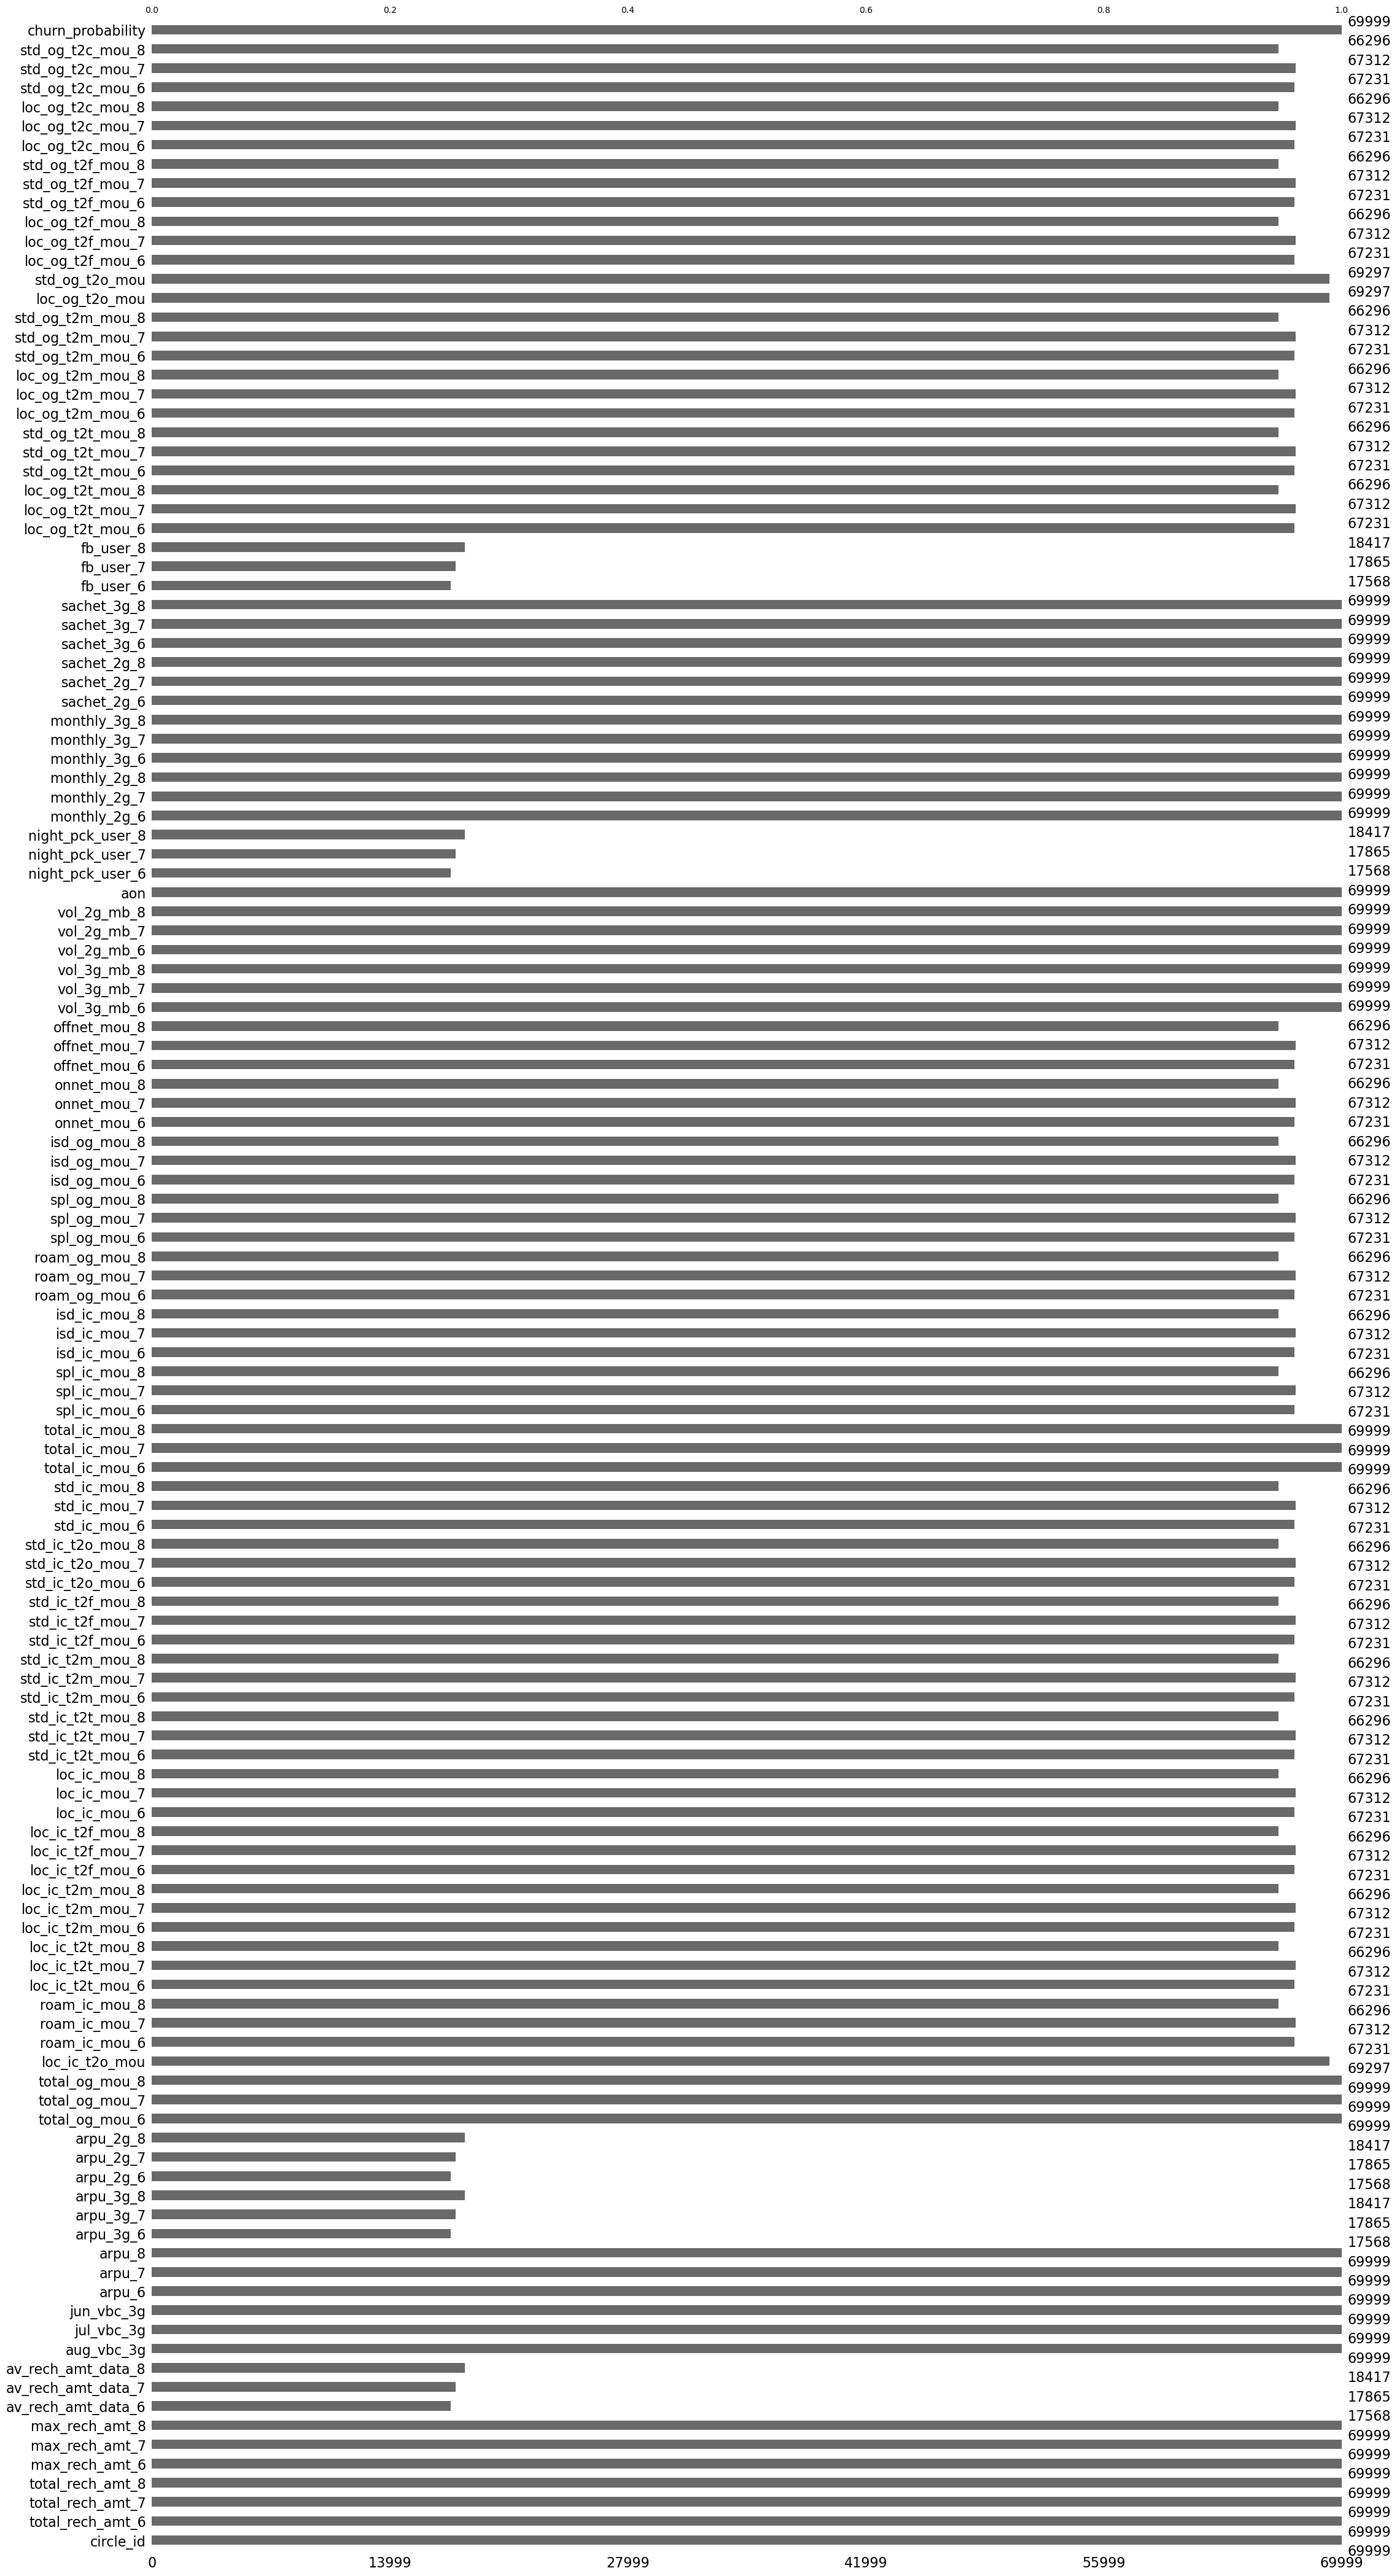

In [15]:
msno.bar(data)

<Axes: >

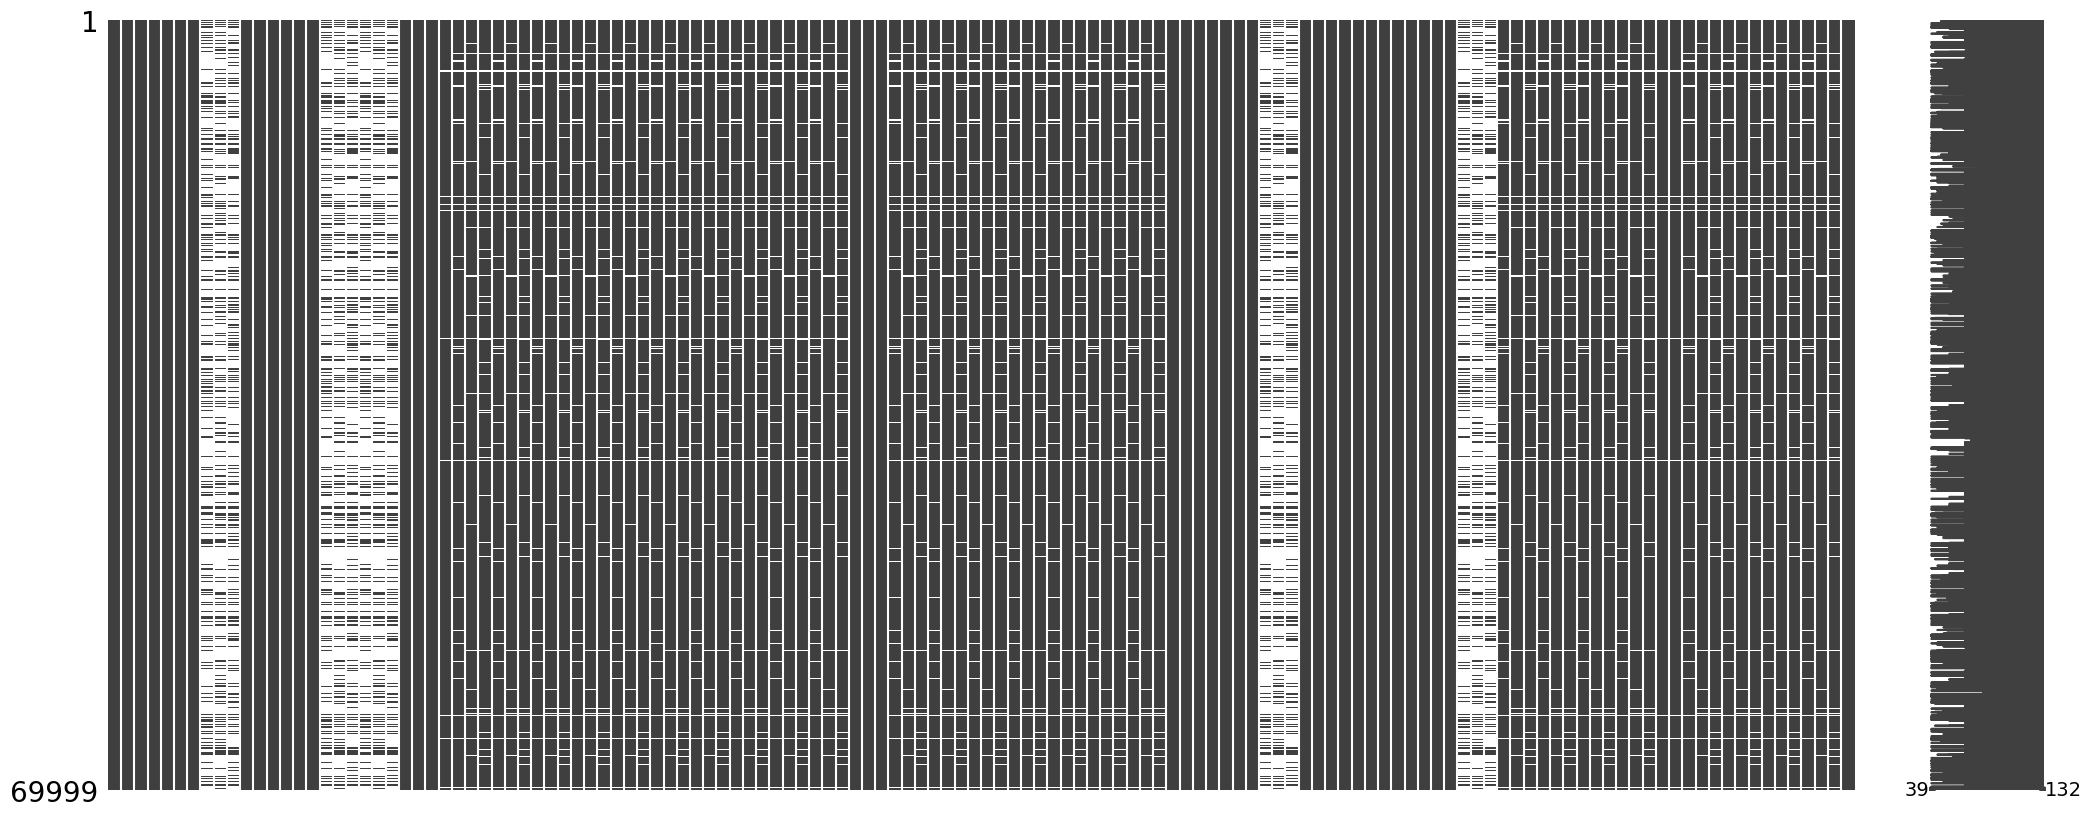

In [16]:
msno.matrix(data)

In [17]:
# Calculating the Missing Percentage values

missing_data_percent = 100*(data.isnull().sum()/len(data))
missing_data_percent

circle_id            0.000000
total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
max_rech_amt_6       0.000000
                       ...   
loc_og_t2c_mou_8     5.290076
std_og_t2c_mou_6     3.954342
std_og_t2c_mou_7     3.838626
std_og_t2c_mou_8     5.290076
churn_probability    0.000000
Length: 132, dtype: float64

In [18]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index # checks for columns with missing data percentages less than or equal to 40% (le stands for "less than or equal").
new_vars

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g',
       ...
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'churn_probability'],
      dtype='object', length=117)

In [ ]:
# Drop columns not in `new_vars`
data_f = data[new_vars]

# Check shapes
data_f.shape, data.shape


((69999, 117), (69999, 132))

### Imputing the Values those are missing for the new variables 

In [20]:
missing_data_percent_nv = data_f.isnull().any()
impute_cols = missing_data_percent_nv[missing_data_percent_nv.gt(0)].index # The gt(0) function is a shorthand for "greater than 0"
impute_cols

Index(['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_6',
       'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offne

<Axes: >

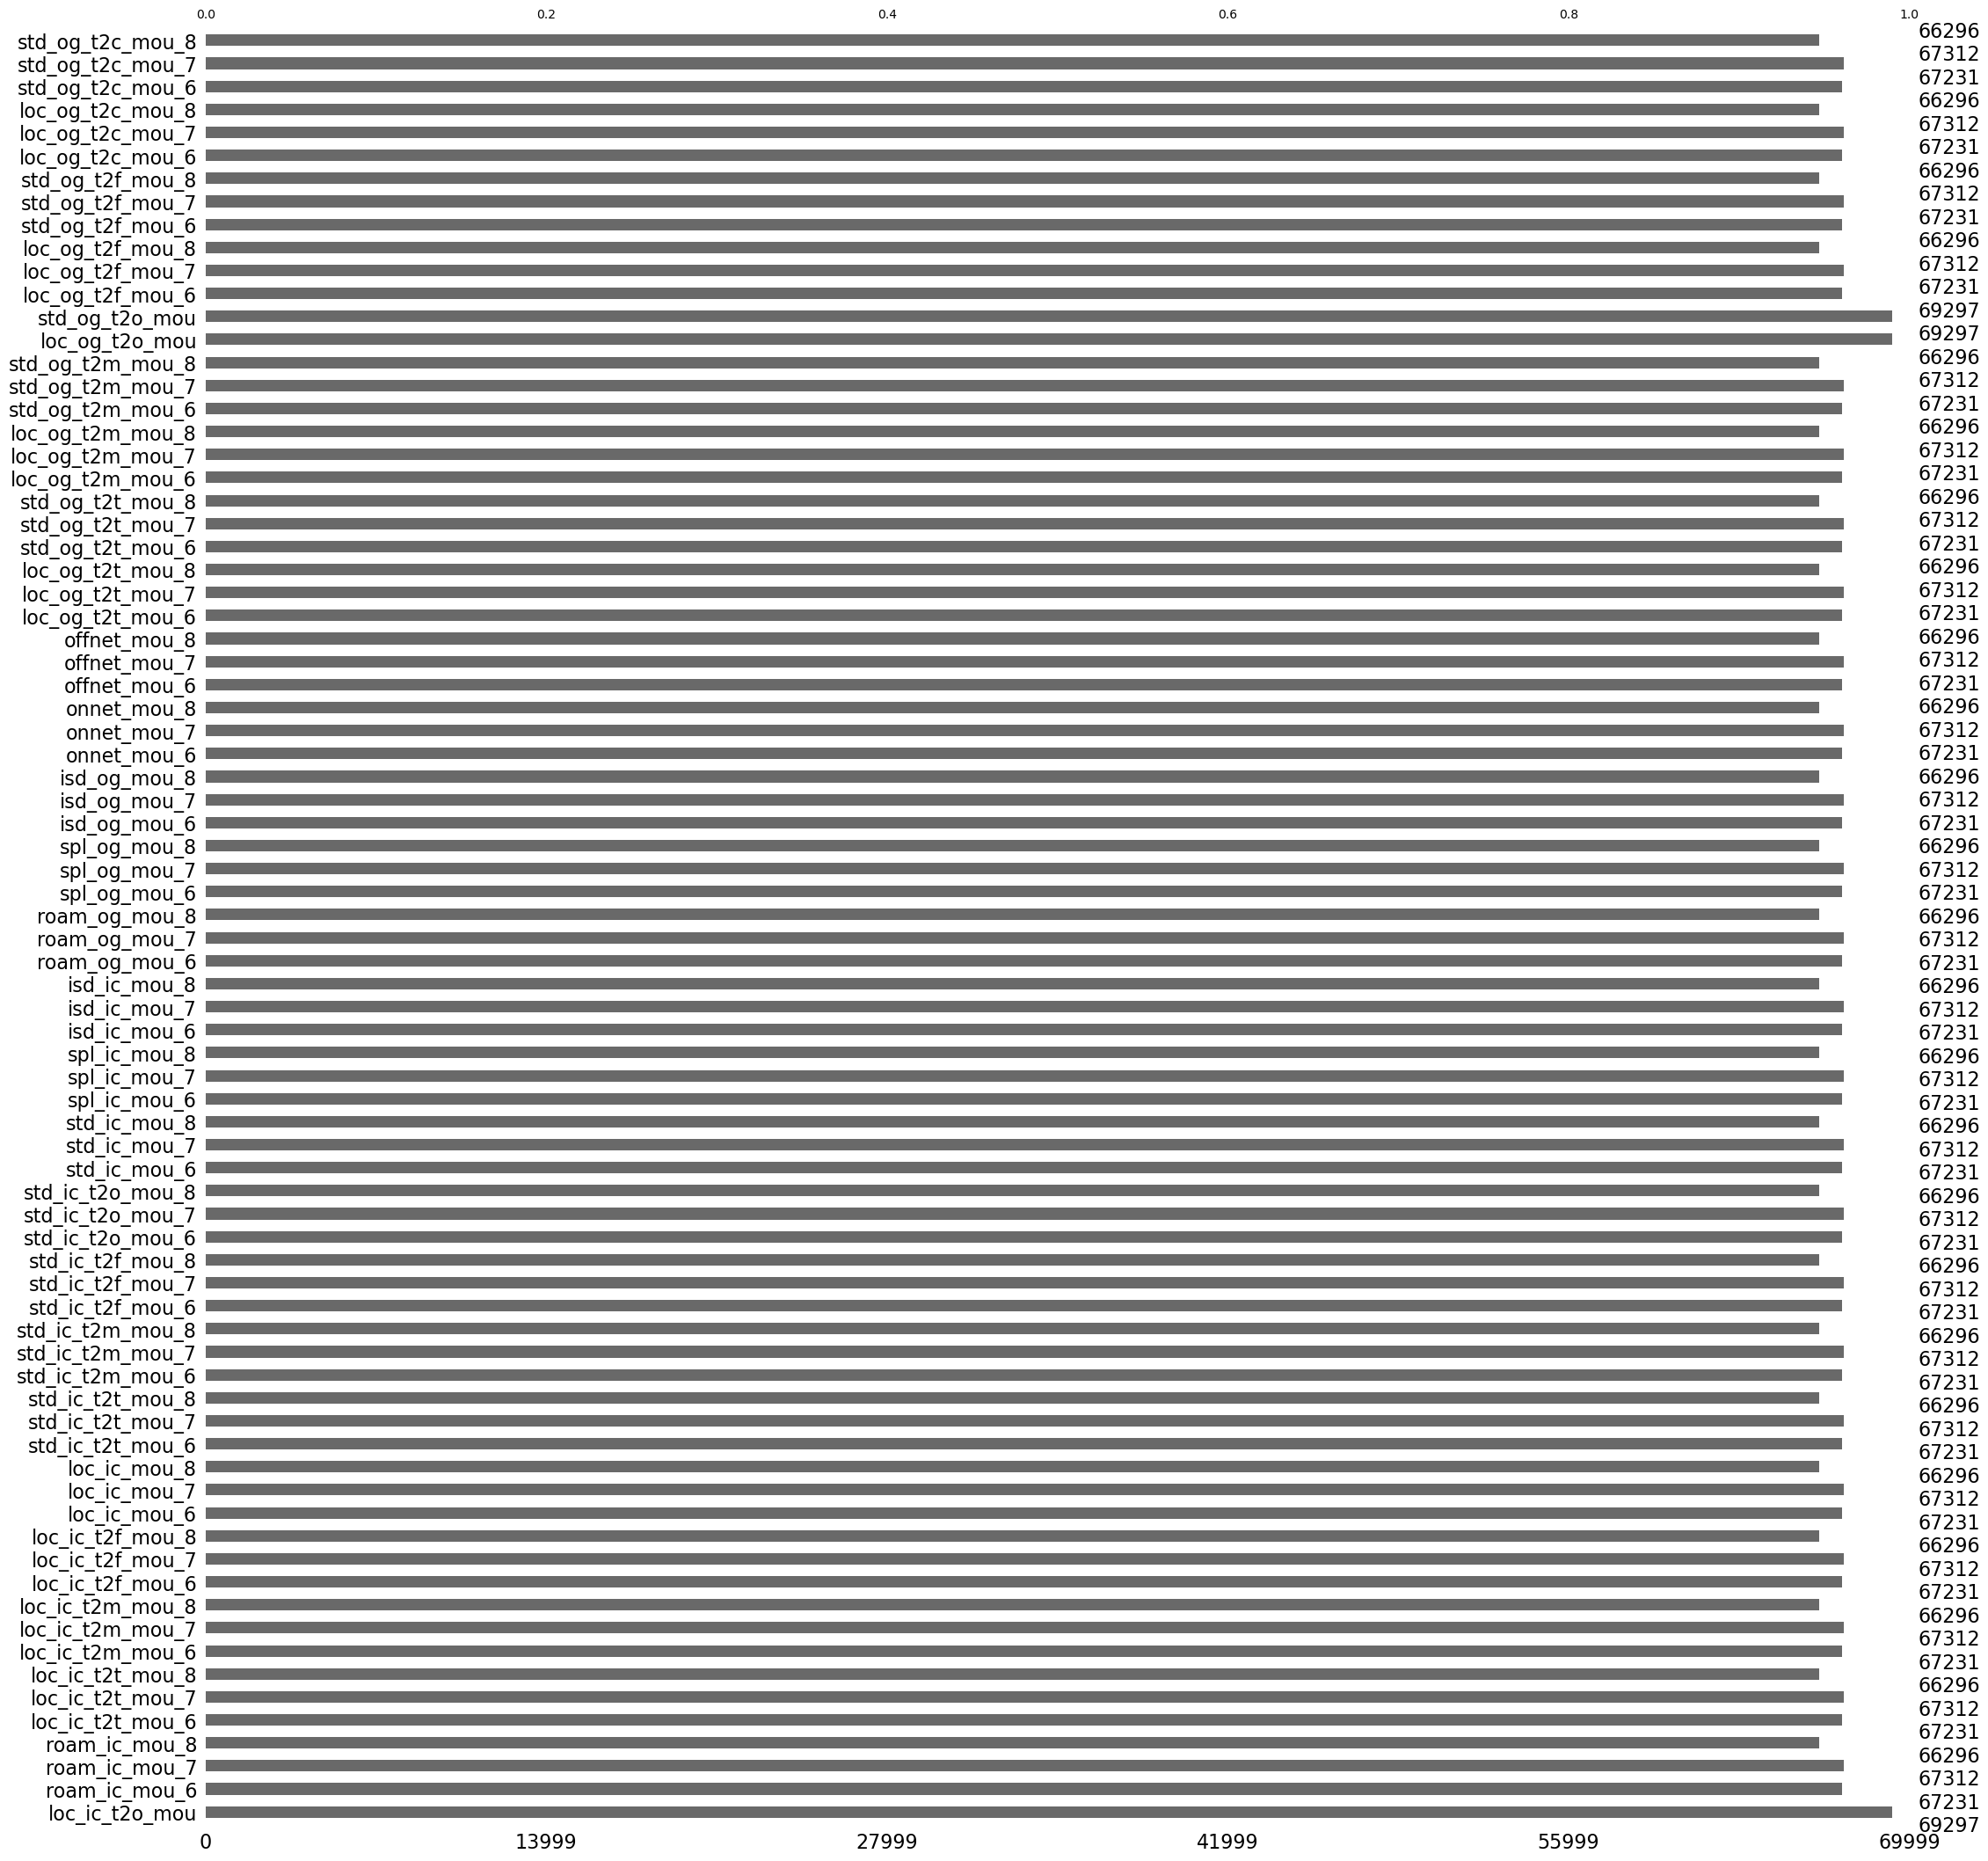

In [21]:
msno.bar(data_f[impute_cols])

In [22]:
mice_imputer = IterativeImputer(max_iter=10, random_state=42  , n_nearest_features=5,initial_strategy='median')
data_f[impute_cols] = mice_imputer.fit_transform(data_f[impute_cols])

<Axes: >

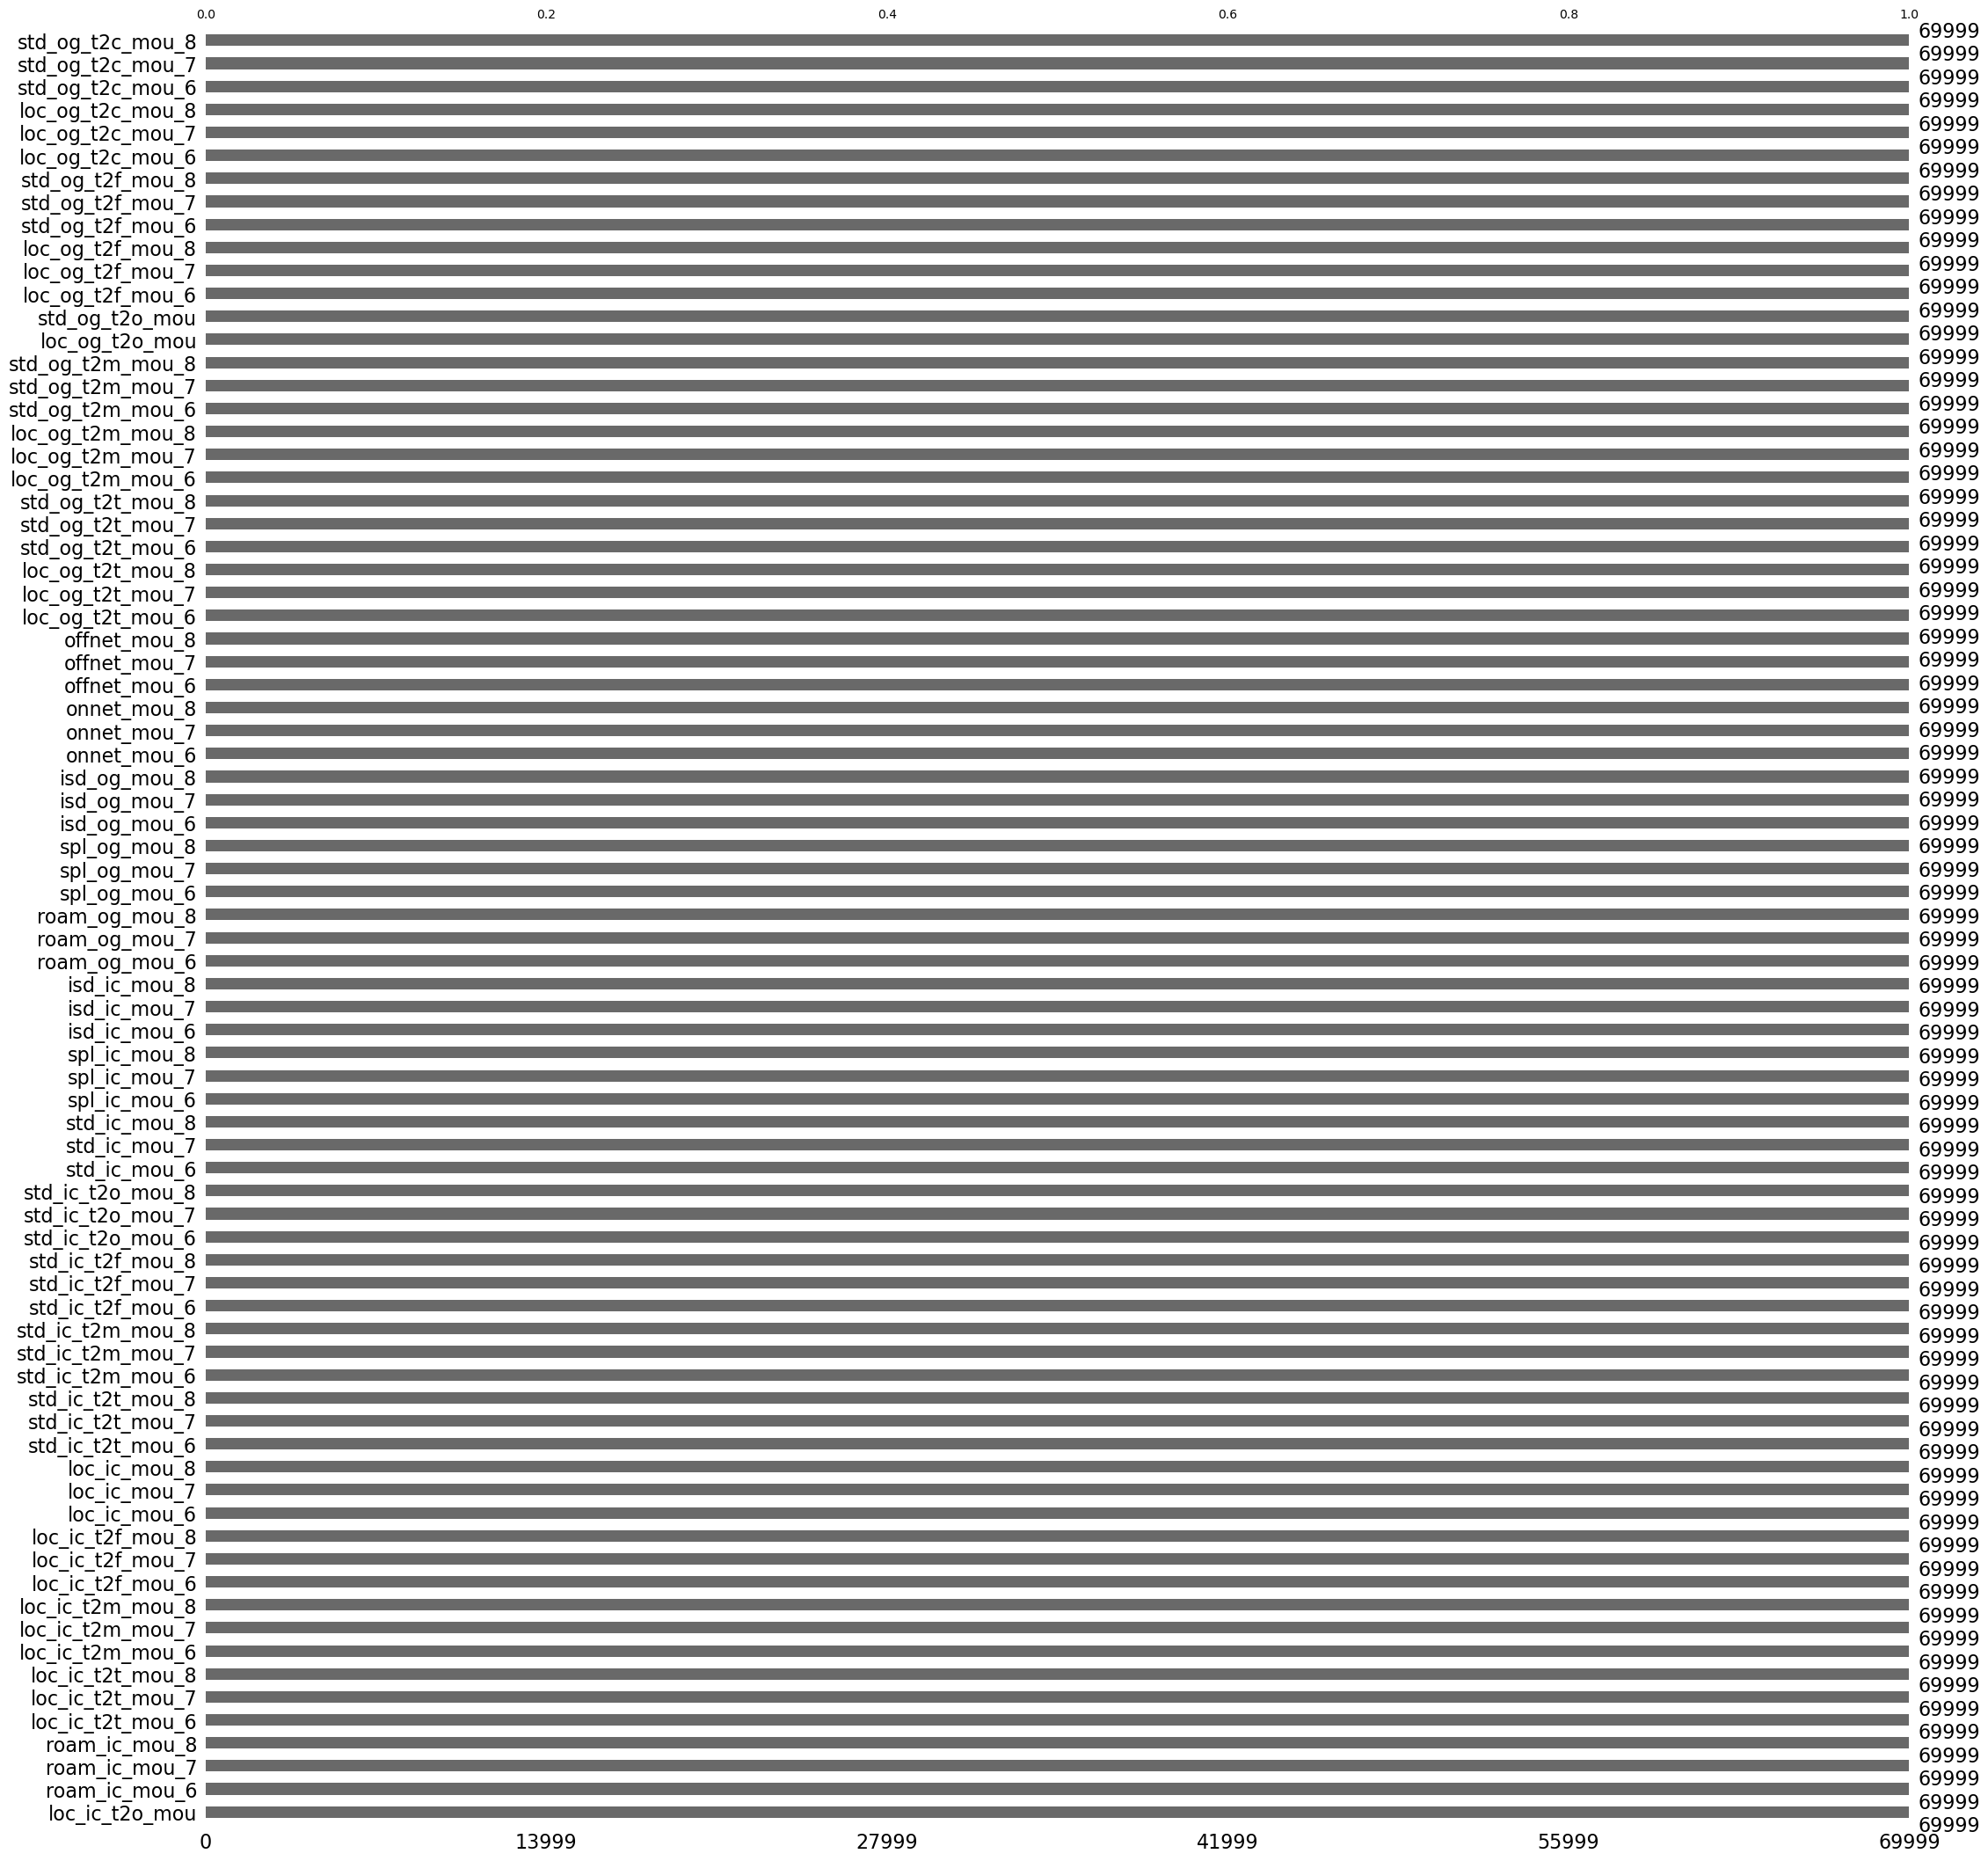

In [23]:
msno.bar(data_f[impute_cols])

In [24]:
data_f.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109                77                65                10   
1         109                 0               145                50   
2         109                70               120                 0   
3         109               160               240               130   
4         109               290               136               122   

    max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  \
id                                                                           
0               65              65              10         0.0         0.0   
1                0             145              50         0.0         0.0   
2               70              70               0         0.0         0.0   
3              110             110              50         0.0         0.0   
4               50              41              30         0.0         0.0   

    jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
id              ...                                                         
0          0.0  ...              0.00               0.0               0.0   
1          0.0  ...              0.00               0.0               0.0   
2          0.0  ...              0.00               0.0               0.0   
3          0.0  ...              0.56               0.0               0.0   
4          0.0  ...              0.00               0.0               0.0   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  \
id                                                                           
0               0.00              0.00              0.00               0.0   
1               0.00             22.01             29.79               0.0   
2               2.14              0.00              0.00               0.0   
3               0.00              0.00              8.03               0.0   
4               0.00              9.85              0.00               0.0   

    std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
id                                                         
0                0.0               0.0                  0  
1                0.0               0.0                  0  
2                0.0               0.0                  0  
3                0.0               0.0                  0  
4                0.0               0.0                  0  

[5 rows x 117 columns]

In [25]:
data_f.describe()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
count    69999.0      69999.000000      69999.000000      69999.000000   
mean       109.0        328.139788        322.376363        323.846355   
std          0.0        404.211068        411.070120        426.181405   
min        109.0          0.000000          0.000000          0.000000   
25%        109.0        110.000000        100.000000         90.000000   
50%        109.0        229.000000        220.000000        225.000000   
75%        109.0        438.000000        430.000000        436.000000   
max        109.0      35190.000000      40335.000000      45320.000000   

       max_rech_amt_6  max_rech_amt_7  max_rech_amt_8    aug_vbc_3g  \
count    69999.000000    69999.000000    69999.000000  69999.000000   
mean       104.569265      104.137573      107.540351     68.108597   
std        121.407701      120.782543      124.396750    269.328659   
min          0.000000        0.000000        0.000000      0.000000   
25%         30.000000       30.000000       30.000000      0.000000   
50%        110.000000      110.000000       98.000000      0.000000   
75%        120.000000      128.000000      144.000000      0.000000   
max       4010.000000     3299.000000     4449.000000  12916.220000   

         jul_vbc_3g   jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  \
count  69999.000000  69999.00000  ...      69999.000000      69999.000000   
mean      65.935830     60.07674  ...          1.121430          1.072492   
std      267.899034    257.22681  ...          7.974359          8.177923   
min        0.000000      0.00000  ...          0.000000         -0.591948   
25%        0.000000      0.00000  ...          0.000000          0.000000   
50%        0.000000      0.00000  ...          0.000000          0.000000   
75%        0.000000      0.00000  ...          0.000000          0.000000   
max     9165.600000  11166.21000  ...        628.560000        465.790000   

       std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean           1.041788          1.128586          1.358420          1.417824   
std            7.514672          5.631844          7.760969          6.386369   
min           -2.443565         -0.665662          0.000000         -1.569337   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.150000   
max          354.160000        342.860000        916.240000        351.830000   

       std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
count           69999.0           69999.0           69999.0       69999.000000  
mean                0.0               0.0               0.0           0.101887  
std                 0.0               0.0               0.0           0.302502  
min                 0.0               0.0               0.0           0.000000  
25%                 0.0               0.0               0.0           0.000000  
50%                 0.0               0.0               0.0           0.000000  
75%                 0.0               0.0               0.0           0.000000  
max                 0.0               0.0               0.0           1.000000  

[8 rows x 117 columns]

In [26]:
data_f.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 117 columns):
 #    Column             Dtype  
---   ------             -----  
 0    circle_id          int64  
 1    total_rech_amt_6   int64  
 2    total_rech_amt_7   int64  
 3    total_rech_amt_8   int64  
 4    max_rech_amt_6     int64  
 5    max_rech_amt_7     int64  
 6    max_rech_amt_8     int64  
 7    aug_vbc_3g         float64
 8    jul_vbc_3g         float64
 9    jun_vbc_3g         float64
 10   arpu_6             float64
 11   arpu_7             float64
 12   arpu_8             float64
 13   total_og_mou_6     float64
 14   total_og_mou_7     float64
 15   total_og_mou_8     float64
 16   loc_ic_t2o_mou     float64
 17   roam_ic_mou_6      float64
 18   roam_ic_mou_7      float64
 19   roam_ic_mou_8      float64
 20   loc_ic_t2t_mou_6   float64
 21   loc_ic_t2t_mou_7   float64
 22   loc_ic_t2t_mou_8   float64
 23   loc_ic_t2m_mou_6   float64
 24   loc_ic_t2m_mou_7   float64
 25 

# ___Exploratory Data Analysis (EDA)___

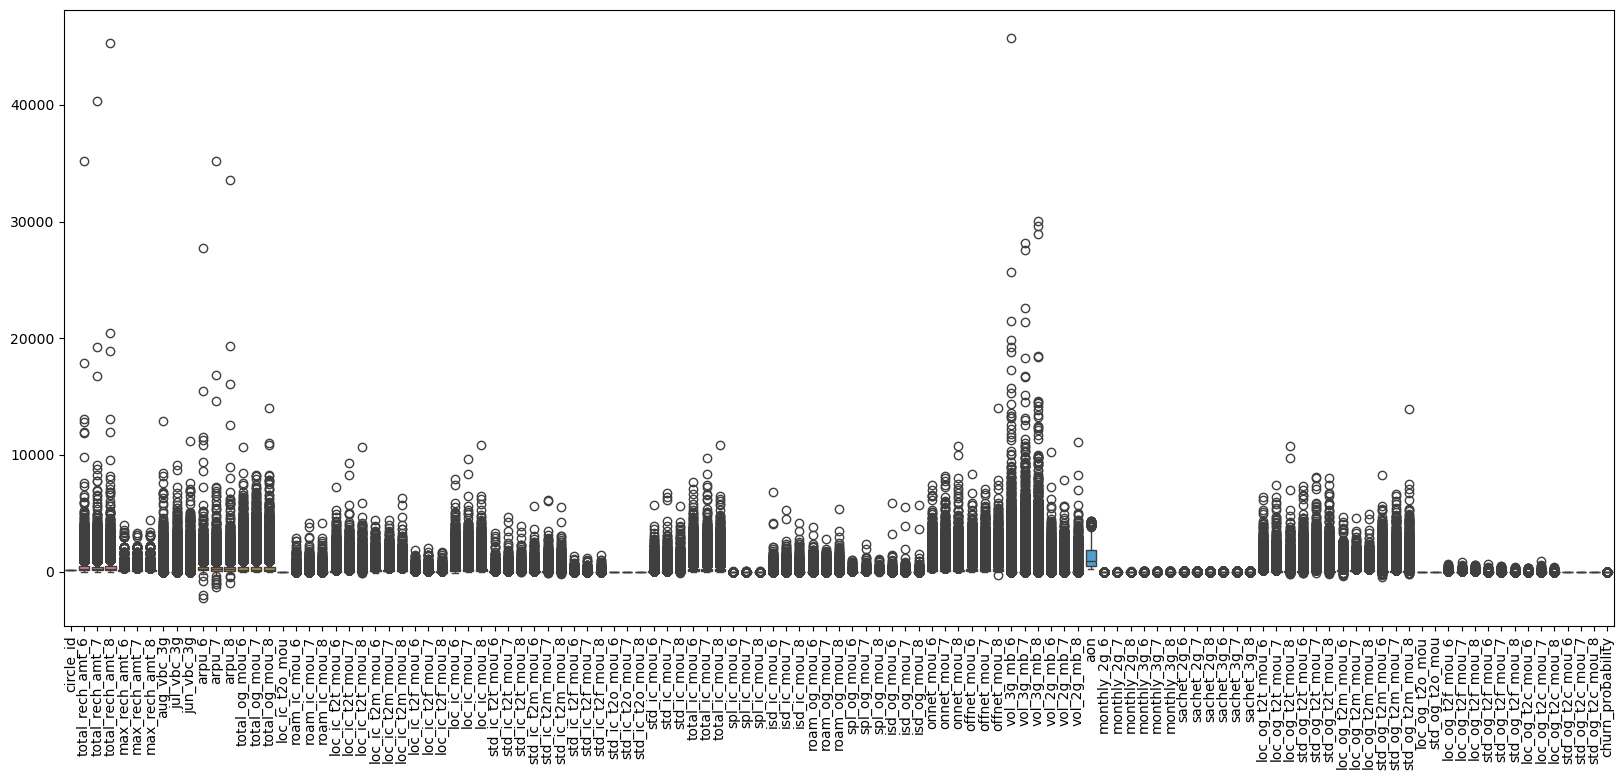

In [27]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data = data_f)
plt.show()

## Filter high-value customers
#### to get a clearer view using EDA

In [28]:
id_cols=[x for x in test_df.columns if 'id' in x]
amt_cols=[x for x in test_df.columns if 'amt' in x]
mou_cols=[x for x in test_df.columns if 'mou' in x]
date_cols=[x for x in test_df.columns if 'date' in x]
arpu_cols=['arpu_6','arpu_7','arpu_8']
aon_cols=['aon']
target_col=['churn_probability']
other_col=[x for x in list(test_df.columns) if x not in id_cols + amt_cols + mou_cols + date_cols + arpu_cols + aon_cols + target_col] 

In [29]:
id_cols=[x for x in unseen_df.columns if 'id' in x]
amt_cols=[x for x in unseen_df.columns if 'amt' in x]
mou_cols=[x for x in unseen_df.columns if 'mou' in x]
date_cols=[x for x in unseen_df.columns if 'date' in x]
arpu_cols=['arpu_6','arpu_7','arpu_8']
aon_cols=['aon']
target_col=['churn_probability']
other_col=[x for x in list(unseen_df.columns) if x not in id_cols + amt_cols + mou_cols + date_cols + arpu_cols + aon_cols + target_col] 

In [30]:
test_df[arpu_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   arpu_6  69999 non-null  float64
 1   arpu_7  69999 non-null  float64
 2   arpu_8  69999 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [31]:
test_df[arpu_cols].describe()

arpu_6        arpu_7        arpu_8
count  69999.000000  69999.000000  69999.000000
mean     283.134365    278.185912    278.858826
std      334.213918    344.366927    351.924315
min    -2258.709000  -1289.715000   -945.808000
25%       93.581000     86.714000     84.095000
50%      197.484000    191.588000    192.234000
75%      370.791000    365.369500    369.909000
max    27731.088000  35145.834000  33543.624000

In [32]:
test_df['avg_arpu']=(test_df['arpu_6']+test_df['arpu_6']+test_df['arpu_6'])/3

In [33]:
test_df.avg_arpu.quantile(0.7)

323.9982

In [34]:
high_val_cust = test_df.loc[test_df.avg_arpu > test_df.avg_arpu.quantile(0.7), :]
high_val_cust = high_val_cust.reset_index(drop=True)
high_val_cust.shape

(21000, 173)

In [35]:
high_val_cust['tc_mou_8'] = high_val_cust.total_ic_mou_8 + high_val_cust.total_og_mou_8

In [36]:
high_val_cust['total_internet_mb_8'] =  high_val_cust.vol_2g_mb_8 + high_val_cust.vol_3g_mb_8

In [37]:
high_val_cust['churn'] = high_val_cust.apply(lambda row: 1 if (row.tc_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)

In [38]:
high_val_cust[['churn','total_ic_mou_8','total_og_mou_8','vol_2g_mb_8','vol_3g_mb_8']]

churn  total_ic_mou_8  total_og_mou_8  vol_2g_mb_8  vol_3g_mb_8
0          0           17.31            3.14         0.00          0.0
1          0           26.99          687.41         0.00          0.0
2          0          369.53          227.41         0.00          0.0
3          0          629.94          391.53       354.35          0.0
4          0          203.29          387.81         0.00          0.0
...      ...             ...             ...          ...          ...
20995      0           98.06          474.51         0.00          0.0
20996      0          366.89          242.69         0.00          0.0
20997      0          551.36         1099.61         0.00          0.0
20998      0          318.86          915.38         0.00          0.0
20999      0          414.54          342.29         0.00          0.0

[21000 rows x 5 columns]

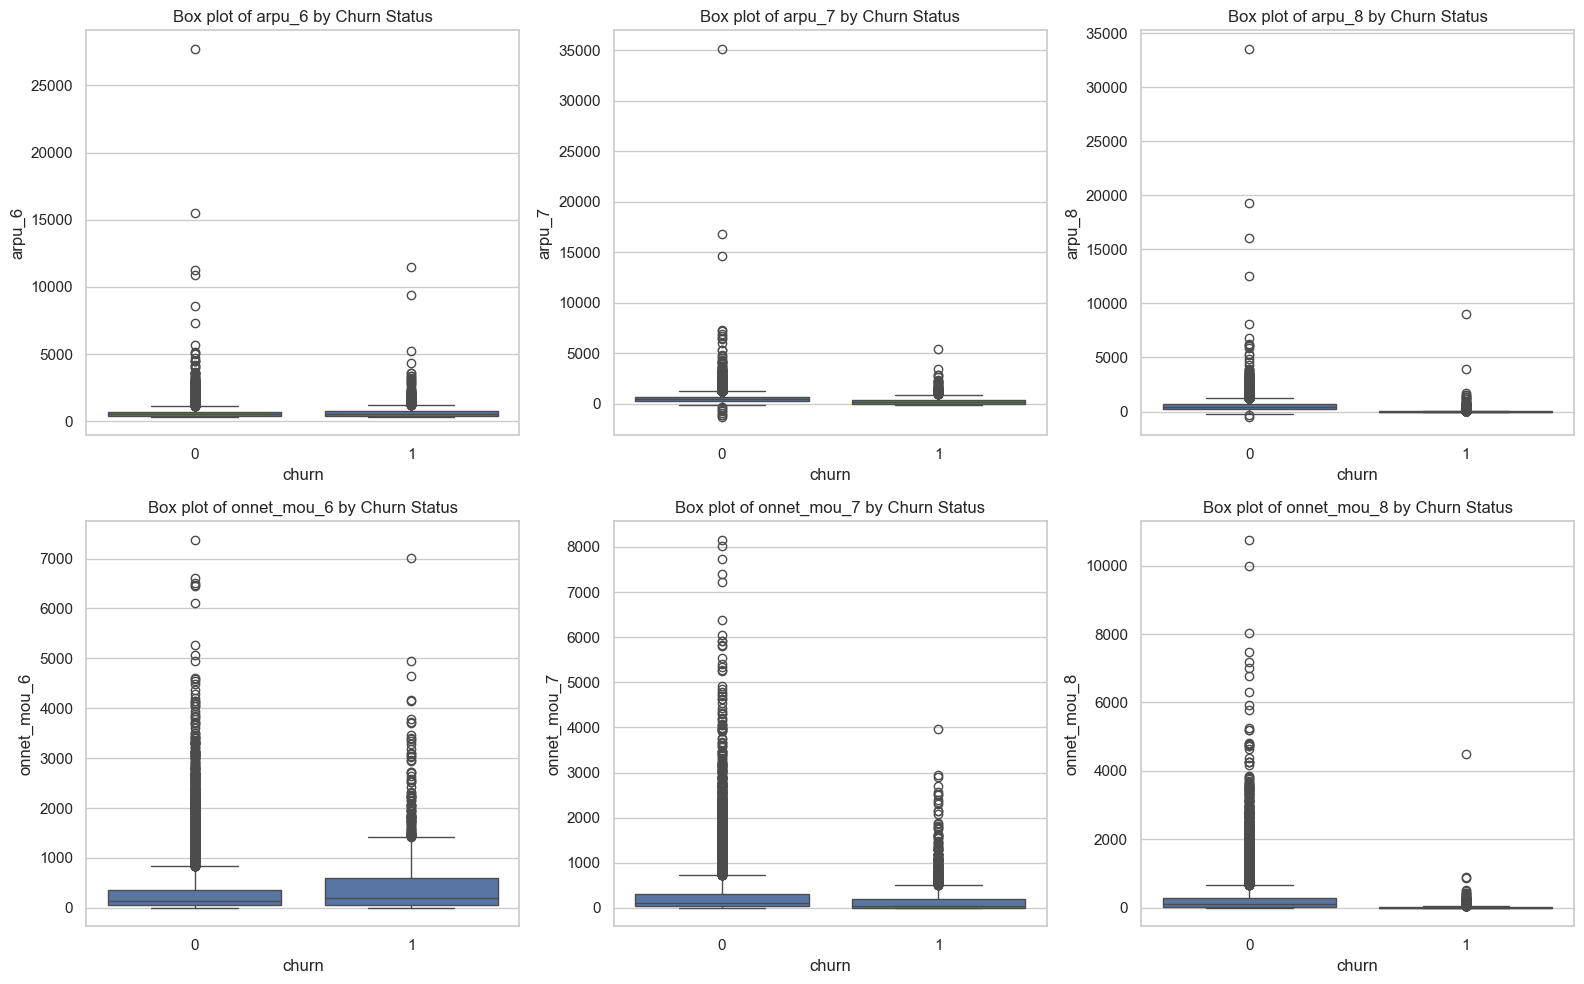

In [39]:
sns.set(style="whitegrid")


features_to_plot = ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'churn']

# Box plots to visualize the distribution of these features, separated by churn status
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_to_plot[:-1]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='churn', y=feature, data=high_val_cust)
    plt.title(f'Box plot of {feature} by Churn Status')

plt.tight_layout()
plt.show()

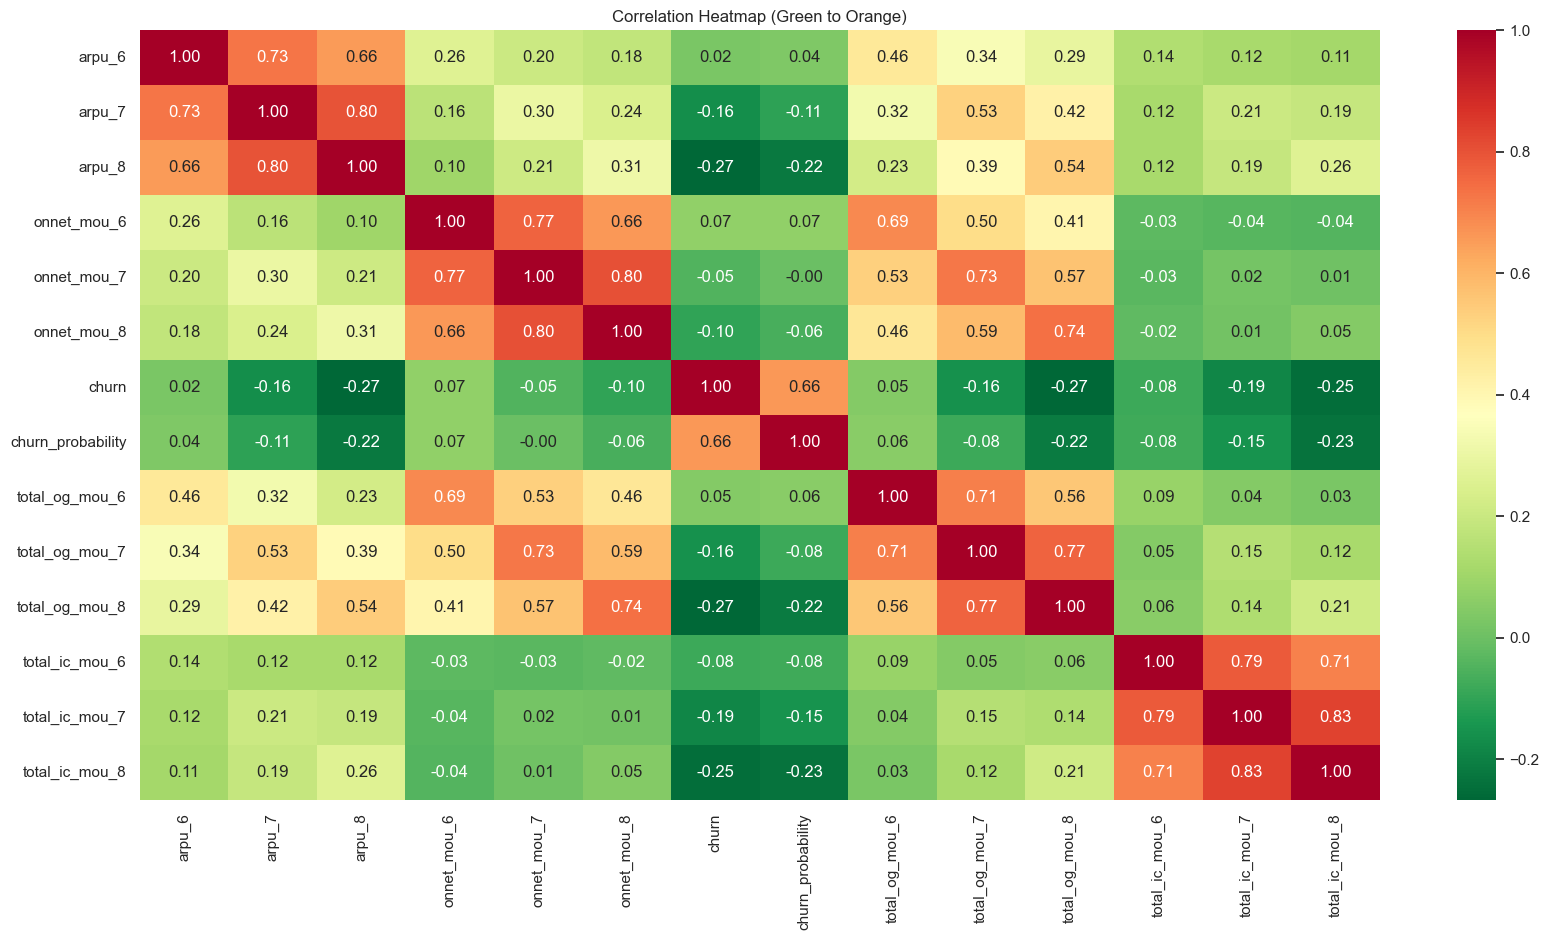

In [40]:
plt.figure(figsize=(20, 10))
mou_total = [col for col in high_val_cust.columns if 'mou' in col.lower() and 'total' in col.lower()]
correlation_matrix = high_val_cust[['arpu_6', 'arpu_7', 'arpu_8','onnet_mou_6', 
                                    'onnet_mou_7', 'onnet_mou_8','churn',
                                    'churn_probability']+mou_total].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn_r', cbar=True)
plt.title('Correlation Heatmap (Green to Orange)')
plt.show()

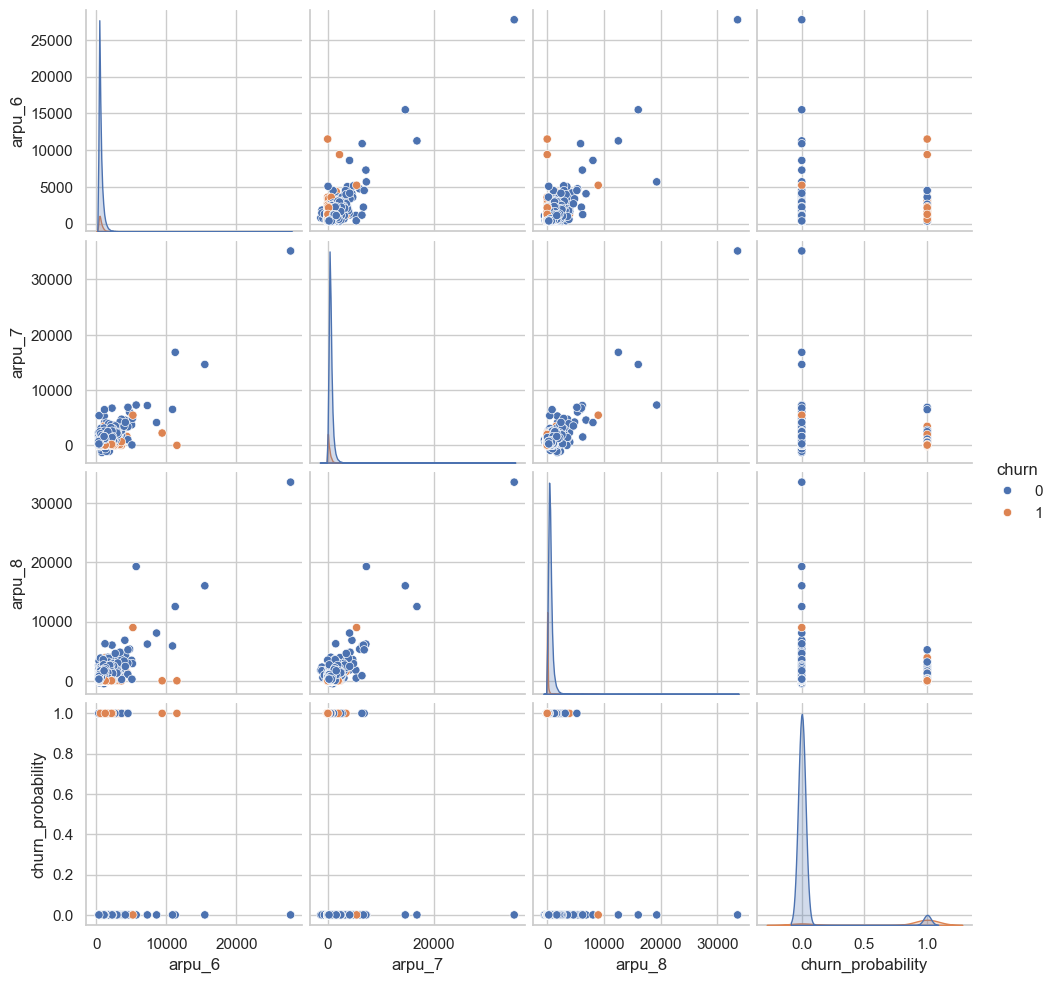

In [41]:
selected_for_pairplot = [
    'arpu_6', 'arpu_7', 'arpu_8', 
     'churn', 'churn_probability'
]

sns.pairplot(high_val_cust[selected_for_pairplot], hue='churn')
plt.show()

In [42]:
amount_data = test_df.loc[:, test_df.columns.str.contains('amt')]

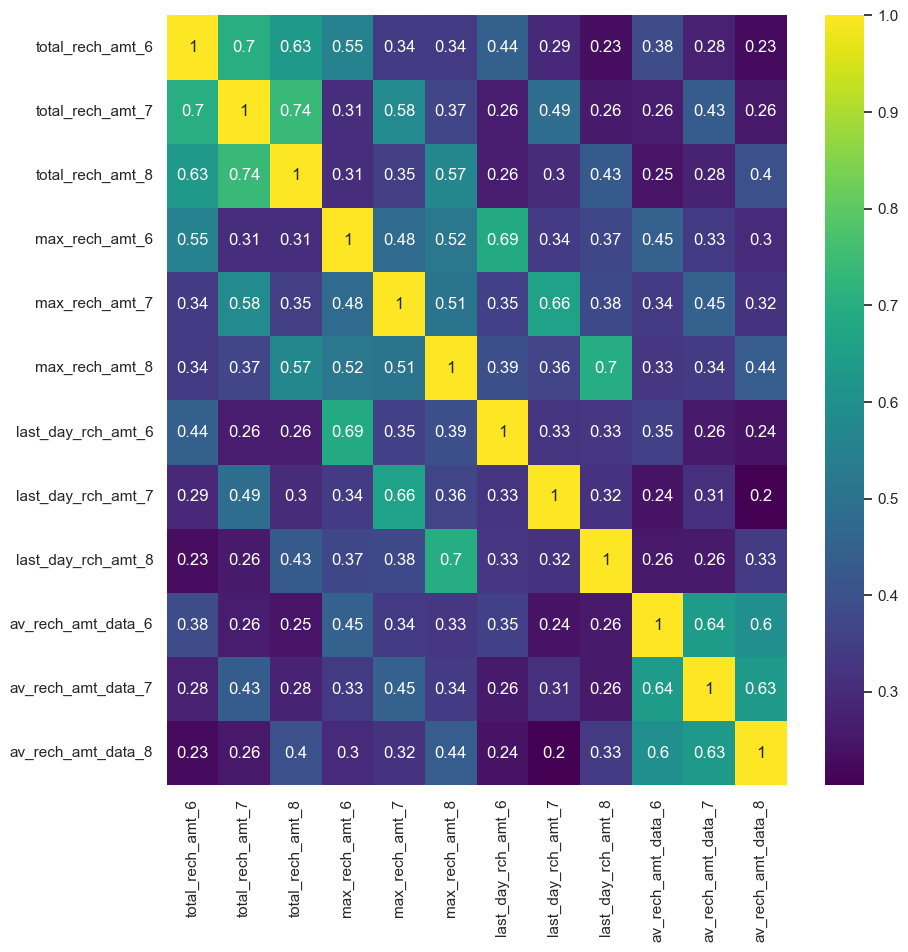

In [43]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

In [44]:
data2g = test_df.loc[:, test_df.columns.str.contains('2g')]
data3g = test_df.loc[:, test_df.columns.str.contains('3g')]

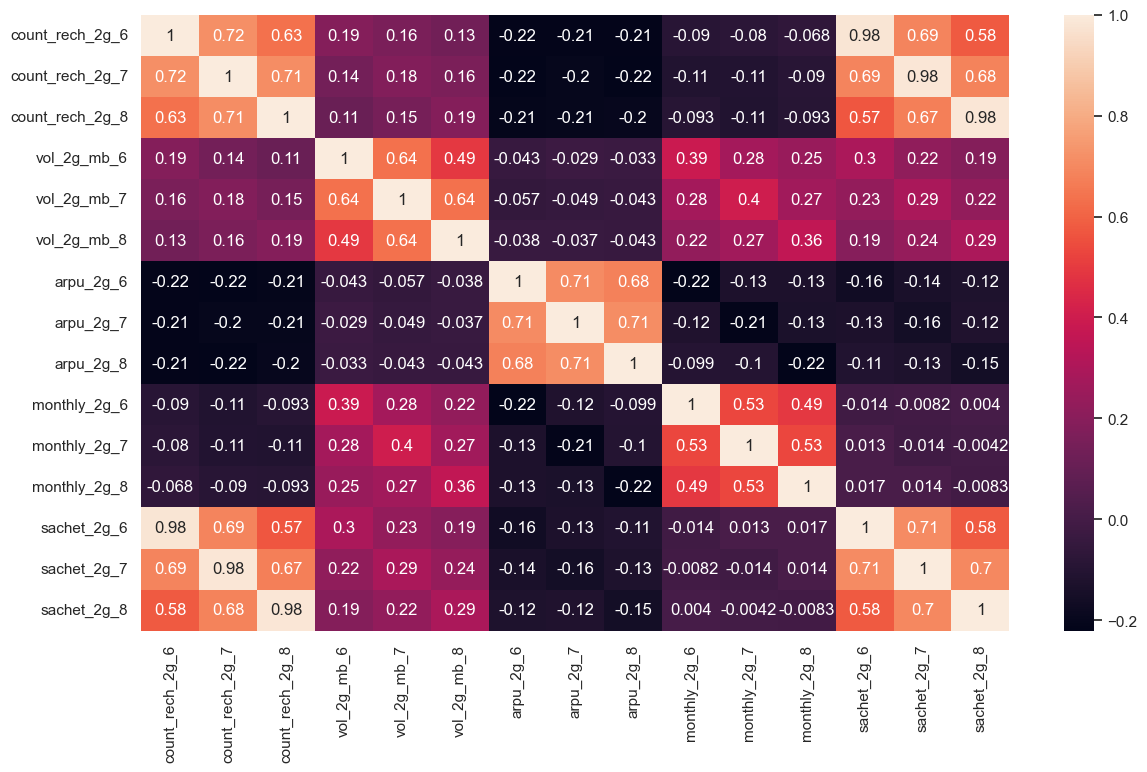

In [45]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

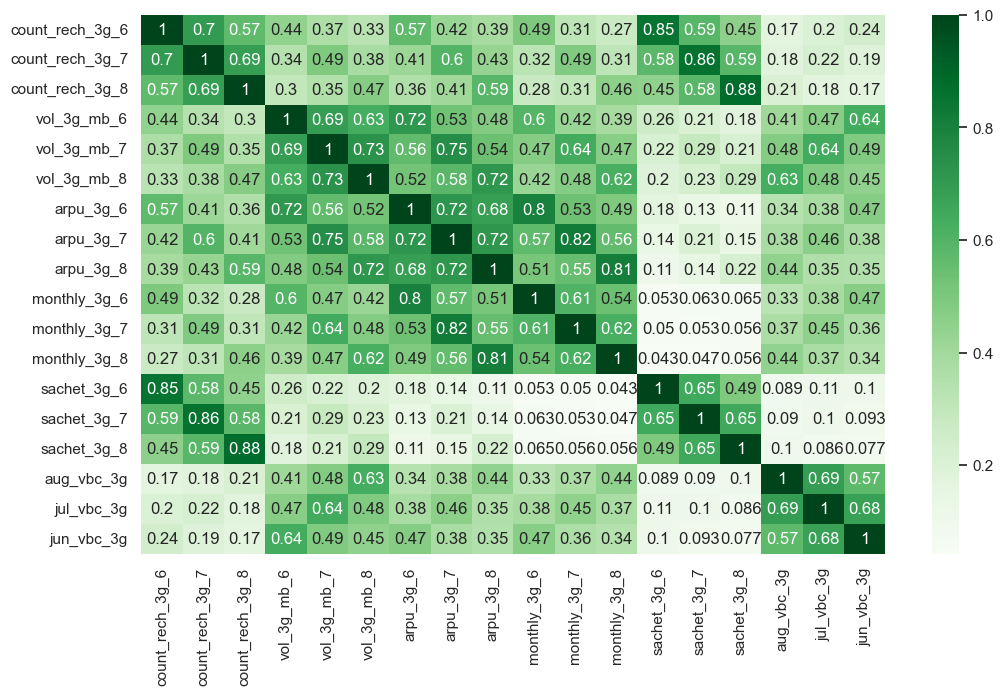

In [46]:
#data3g
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

In [47]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_cust['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

In [48]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_cust['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

## Handeling Outliers
Features show there a lot of outliers. These can be capped with k-sigma method.

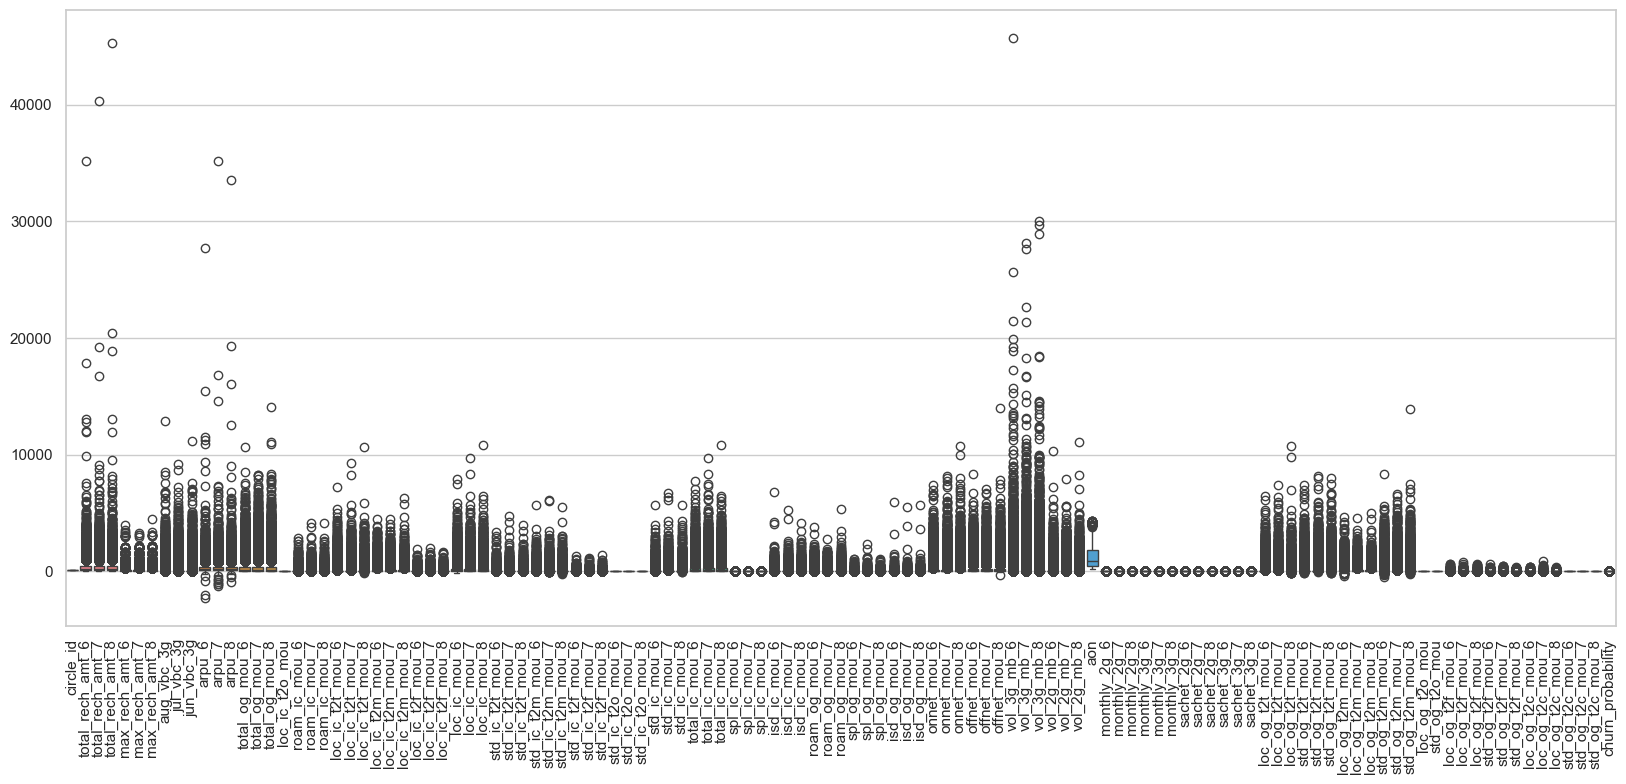

In [49]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data = data_f)
plt.show()

In [50]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [51]:
data_f2 = data_f.apply(cap_outliers, axis=0)
data_f2.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109              77.0              65.0              10.0   
1         109               0.0             145.0              50.0   
2         109              70.0             120.0               0.0   
3         109             160.0             240.0             130.0   
4         109             290.0             136.0             122.0   

    max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  \
id                                                                           
0             65.0            65.0            10.0         0.0         0.0   
1              0.0           145.0            50.0         0.0         0.0   
2             70.0            70.0             0.0         0.0         0.0   
3            110.0           110.0            50.0         0.0         0.0   
4             50.0            41.0            30.0         0.0         0.0   

    jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
id              ...                                                         
0          0.0  ...              0.00               0.0               0.0   
1          0.0  ...              0.00               0.0               0.0   
2          0.0  ...              0.00               0.0               0.0   
3          0.0  ...              0.56               0.0               0.0   
4          0.0  ...              0.00               0.0               0.0   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  \
id                                                                           
0               0.00              0.00          0.000000               0.0   
1               0.00             22.01         20.576932               0.0   
2               2.14              0.00          0.000000               0.0   
3               0.00              0.00          8.030000               0.0   
4               0.00              9.85          0.000000               0.0   

    std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
id                                                         
0                0.0               0.0                  0  
1                0.0               0.0                  0  
2                0.0               0.0                  0  
3                0.0               0.0                  0  
4                0.0               0.0                  0  

[5 rows x 117 columns]

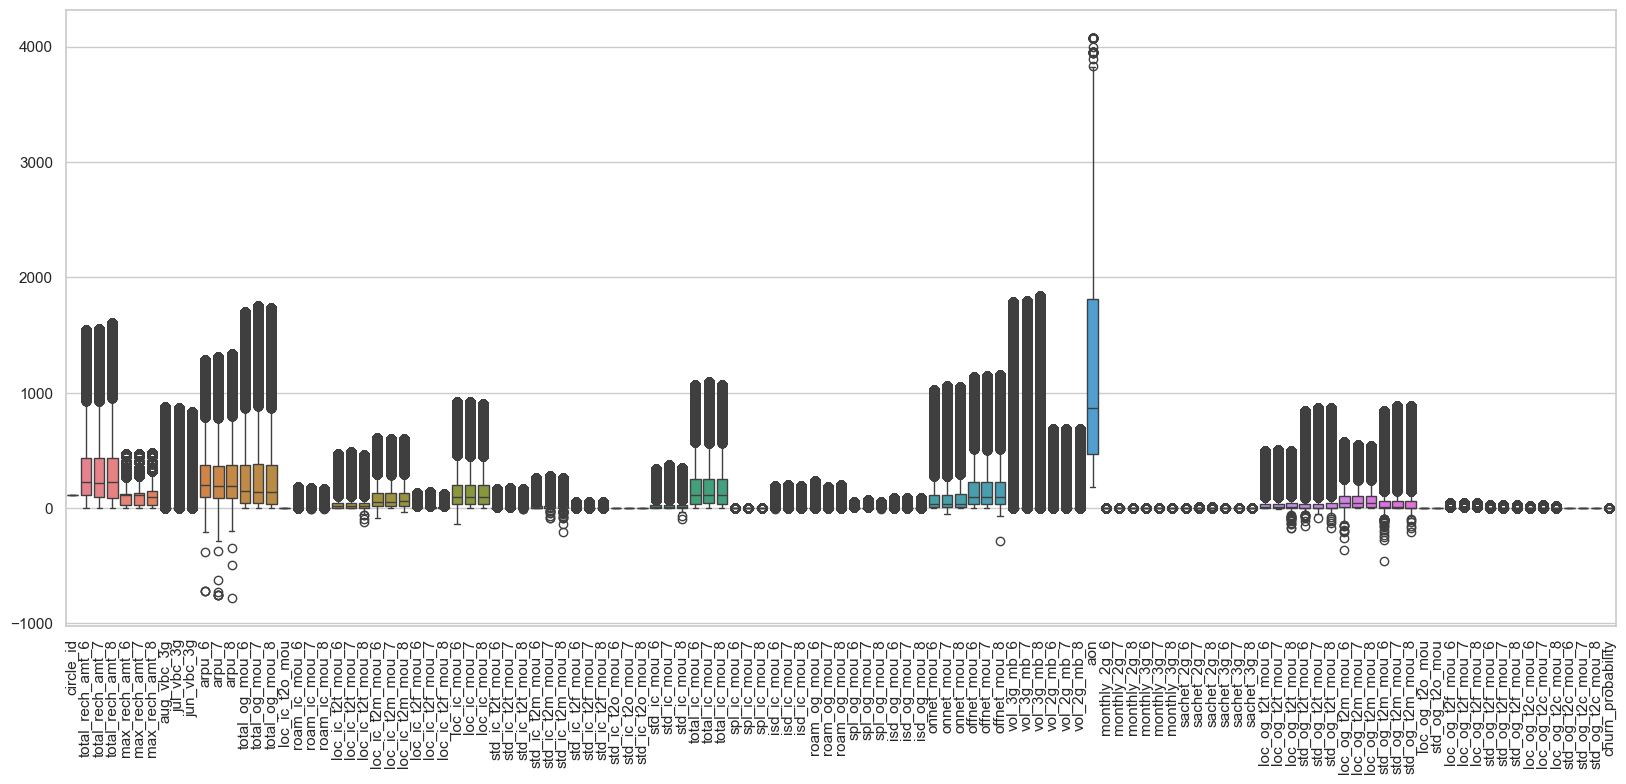

In [52]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data=data_f2)
plt.show()

### DataFrame Scaling

In [53]:
scaler = MinMaxScaler()
df_fs = scaler.fit_transform(data_f2)
X_train_f_s_df = pd.DataFrame(df_fs, columns=data_f2.columns)

In [54]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data=X_train_f_s_df)
plt.show()

In [55]:
X_train_f_s_df.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
0        0.0          0.049975          0.041785          0.006241   
1        0.0          0.000000          0.093212          0.031203   
2        0.0          0.045432          0.077141          0.000000   
3        0.0          0.103844          0.154283          0.081129   
4        0.0          0.188217          0.087427          0.076136   

   max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  \
0        0.138654        0.139340        0.020802         0.0         0.0   
1        0.000000        0.310835        0.104008         0.0         0.0   
2        0.149320        0.150058        0.000000         0.0         0.0   
3        0.234645        0.235806        0.104008         0.0         0.0   
4        0.106657        0.087891        0.062405         0.0         0.0   

   jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0         0.0  ...           0.00000          0.022595          0.093877   
1         0.0  ...           0.00000          0.022595          0.093877   
2         0.0  ...           0.00000          0.022595          0.093877   
3         0.0  ...           0.02236          0.022595          0.093877   
4         0.0  ...           0.00000          0.022595          0.093877   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  \
0          0.035616          0.000000          0.070862               0.0   
1          0.035616          0.893215          1.000000               0.0   
2          0.150117          0.000000          0.070862               0.0   
3          0.035616          0.000000          0.433452               0.0   
4          0.035616          0.399735          0.070862               0.0   

   std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
0               0.0               0.0                0.0  
1               0.0               0.0                0.0  
2               0.0               0.0                0.0  
3               0.0               0.0                0.0  
4               0.0               0.0                0.0  

[5 rows x 117 columns]

## Creating X and Y dataset 


In [56]:
X = X_train_f_s_df.drop(['circle_id'],axis = 1).iloc[:,:-1]
y = X_train_f_s_df.iloc[:,-1]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 115), (14000, 115), (55999,), (14000,))

SMOTE to oversample the minority class in the training data.

In [58]:
# Apply SMOTE outside the pipeline (since it's not a transformer)
smote = SMOTE(sampling_strategy=1.0, random_state=42) #Balances the minority and majority class.

# Perform SMOTE on training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ___Feature engineering and selection___

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [59]:
# Using Random Forest 
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1)

In [60]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap='Oranges'):
    """
    Plots a heatmap for a confusion matrix.
    
    Parameters:
    - cm: Confusion matrix as a 2x2 array or list.
    - title: Title of the plot (default: 'Confusion Matrix').
    - cmap: Color map for the heatmap (default: 'Oranges').
    
    Returns:
    - None
    """
    # Ensure the confusion matrix is a 2x2 numpy array
    cm_array = np.array(cm).reshape(2, 2)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_array, annot=True, cmap=cmap, fmt='g', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

In [61]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train_resampled, dt_classifier.predict(X_train_resampled)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train_resampled, dt_classifier.predict(X_train_resampled)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [62]:
evaluate_model(rf)

Train Accuracy : 1.0
Train Confusion Matrix:
[[50289     0]
 [    0 50289]]
--------------------------------------------------
Test Accuracy : 0.9332142857142857
Test Confusion Matrix:
[[12045   533]
 [  402  1020]]


In [63]:
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})
feature_importances

col  importance
0    total_rech_amt_6    0.004751
1    total_rech_amt_7    0.005653
2    total_rech_amt_8    0.045660
3      max_rech_amt_6    0.005648
4      max_rech_amt_7    0.006055
..                ...         ...
110  loc_og_t2c_mou_7    0.003741
111  loc_og_t2c_mou_8    0.014974
112  std_og_t2c_mou_6    0.000000
113  std_og_t2c_mou_7    0.000000
114  std_og_t2c_mou_8    0.000000

[115 rows x 2 columns]

In [64]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)
plt.bar(feature_importances['col'],feature_importances['importance'])

<BarContainer object of 115 artists>

### ___Using PCA to find the Principle Components for analysis___

In [65]:
# Having a look at the Data Frame
X_train.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
47338          0.000000          0.000000          0.248379        0.000000   
67455          0.112930          0.036642          0.043685        0.063994   
12308          0.051922          0.051428          0.024963        0.063994   
52334          0.146680          0.151711          0.084873        0.234645   
664            0.428356          0.070713          0.000000        0.234645   

       max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
47338        0.000000        0.827907         0.0         0.0         0.0   
67455        0.064311        0.062405         0.0         0.0         0.0   
12308        0.107185        0.062405         0.0         0.0         0.0   
52334        0.235806        0.104008         0.0         0.0         0.0   
664          0.235806        0.000000         0.0         0.0         0.0   

         arpu_6  ...  loc_og_t2f_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
47338  0.444704  ...          0.647548               0.0          0.022595   
67455  0.436406  ...          0.000000               0.0          0.022595   
12308  0.392858  ...          0.000000               0.0          0.022595   
52334  0.428205  ...          0.000000               0.0          0.022595   
664    0.595947  ...          0.024632               0.0          0.022595   

       std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
47338          0.093877          0.035616          0.067367          0.070862   
67455          0.093877          1.000000          0.000000          0.070862   
12308          0.093877          0.035616          0.059250          0.070862   
52334          0.093877          0.035616          0.014204          0.070862   
664            0.100773          0.035616          0.000000          0.096639   

       std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  
47338               0.0               0.0               0.0  
67455               0.0               0.0               0.0  
12308               0.0               0.0               0.0  
52334               0.0               0.0               0.0  
664                 0.0               0.0               0.0  

[5 rows x 115 columns]

In [66]:
pca = PCA(0.9, random_state = 42)
pca_components = pca.fit(X_train_resampled)
pca.components_

array([[ 0.20969023,  0.22306858,  0.1867518 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1098669 ,  0.08827068,  0.01674468, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.08757451,  0.11470807,  0.10326308, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.27100623, -0.12243876, -0.08252751, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05824424, -0.05881688, -0.00322159, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09695075, -0.07626807,  0.01624641, ..., -0.        ,
        -0.        , -0.        ]])

<BarContainer object of 115 artists>

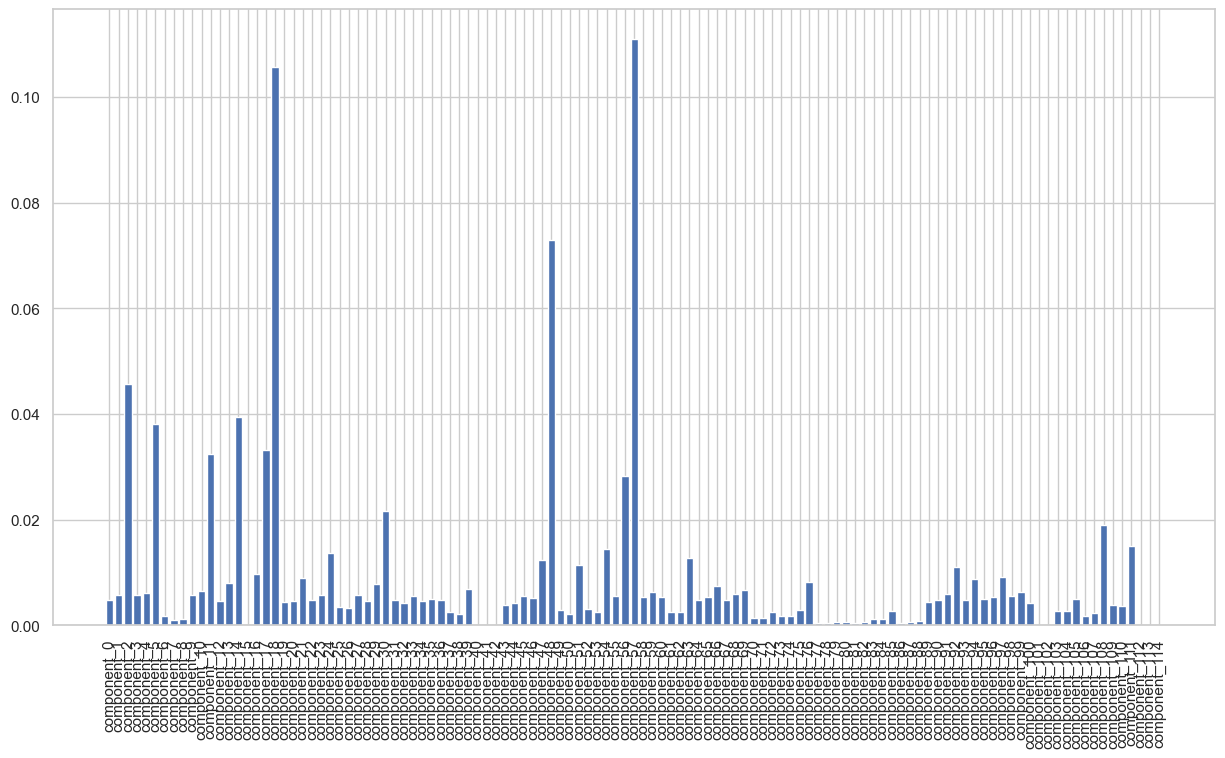

In [67]:
feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(115)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])

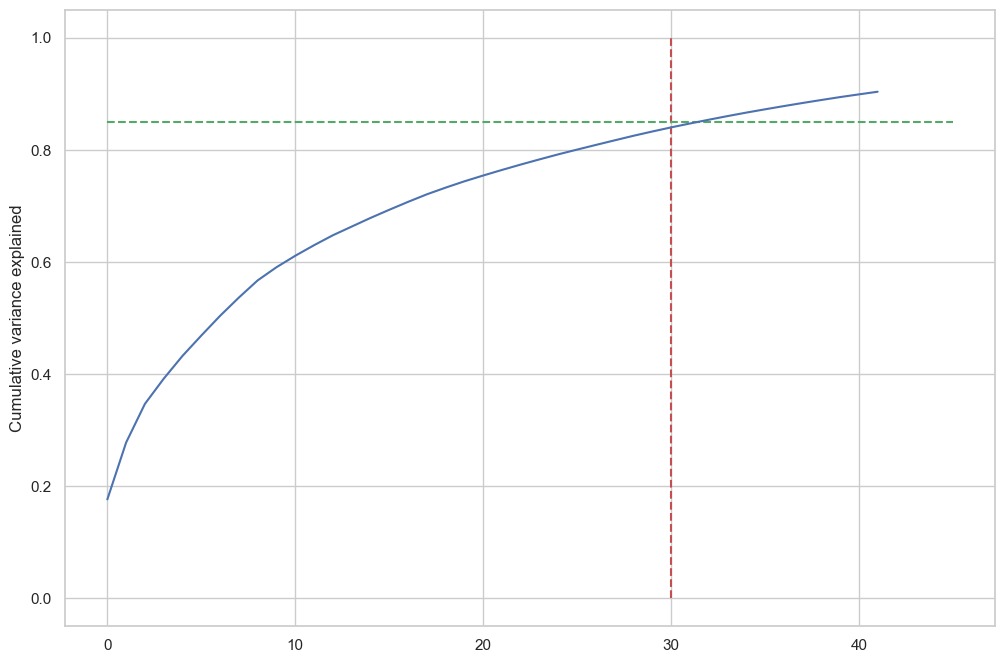

In [68]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.vlines(x=30, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.85, xmax=45, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [69]:
pca_final = IncrementalPCA(n_components=30)
X_train_pca = pca_final.fit_transform(X_train_resampled)
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape, X_train_pca.shape

((30, 30), (100578, 30))

<Axes: >

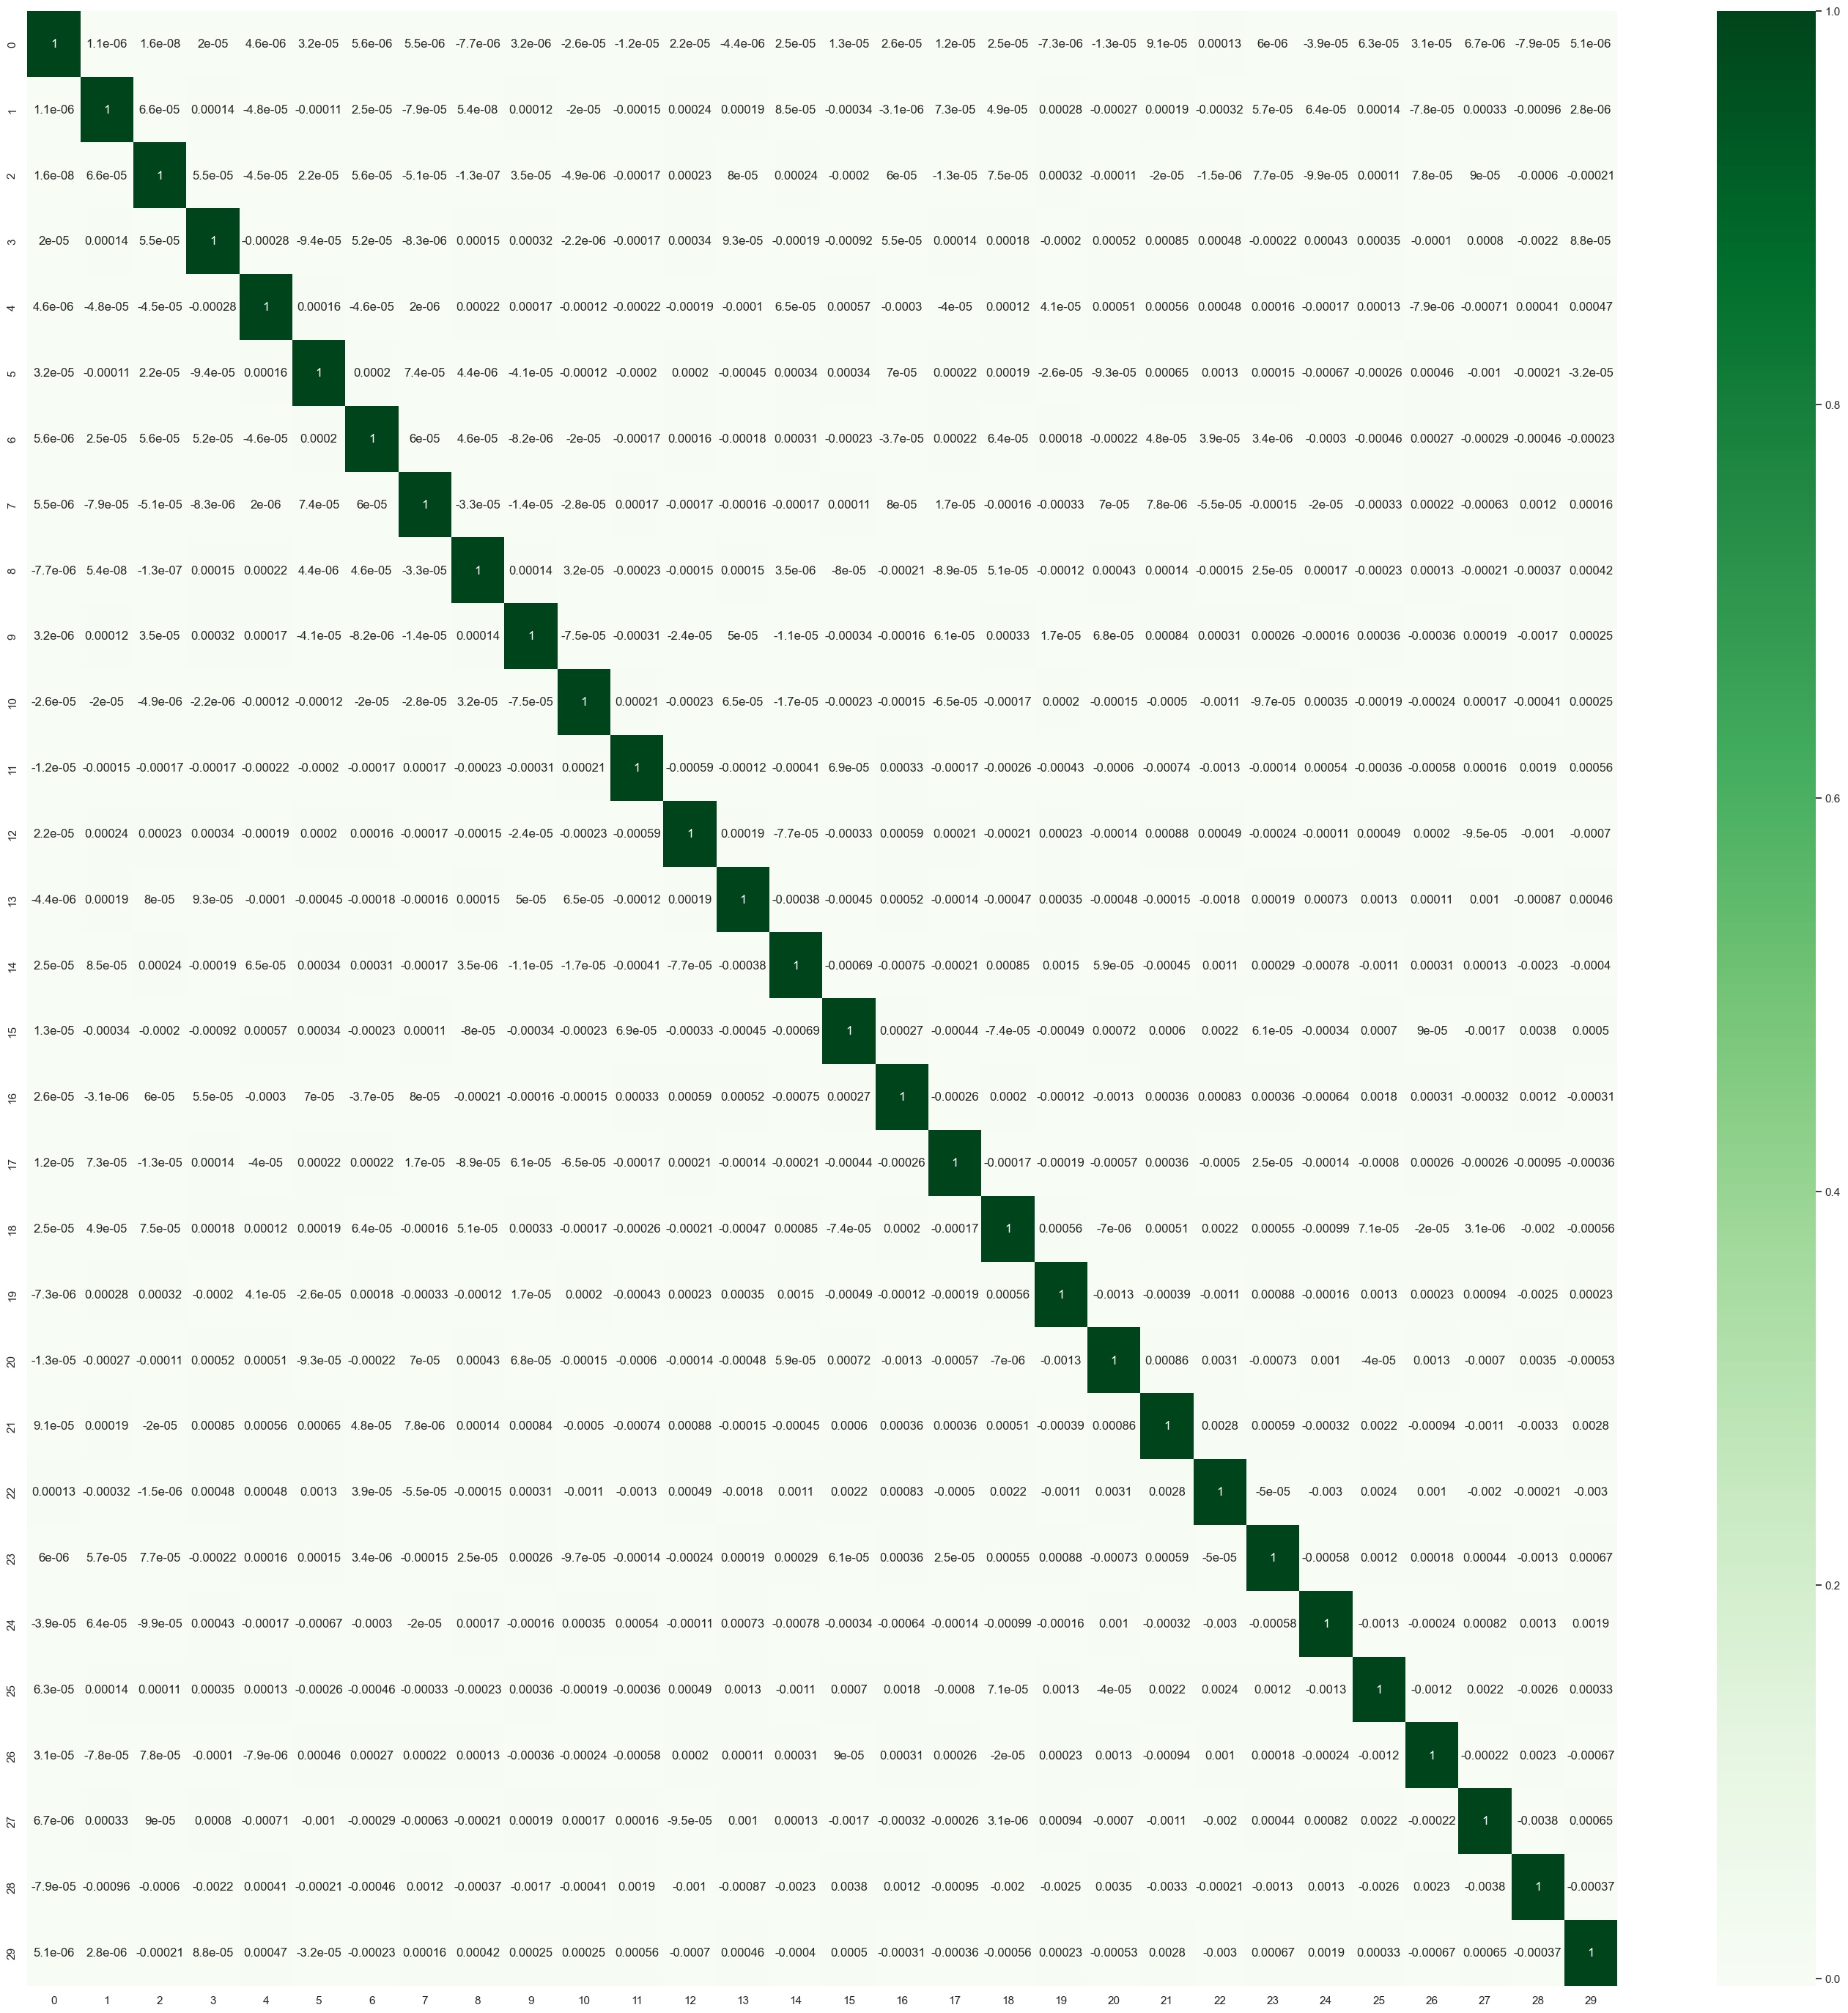

In [70]:
plt.figure(figsize=[35,35])
sns.heatmap(corrmat, annot=True, cmap='Greens')

# ___Model Generation___

# ___First Model - Logistic Regression___
#### ___Applying logistic regression on the Data Selected by PCA___

In [71]:
lr = LogisticRegression()
lr.fit(X_train_pca, y_train_resampled)

LogisticRegression()

In [72]:
lr_sm = sm.GLM(y_train_resampled,(sm.add_constant(X_train_pca)), family = sm.families.Binomial())
model = lr_sm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:               100578
Model:                            GLM   Df Residuals:                   100547
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46603.
Date:                Fri, 17 Jan 2025   Deviance:                       93206.
Time:                        12:25:10   Pearson chi2:                 2.35e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3685
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1916      0.009    -21.671      0.000      -0.209      -0.174
x1            -1.5427      0.017    -92.753      0.000      -1.575      -1.510
x2             1.9709      0.021     95.143      0.000       1.930       2.012
x3            -0.1998      0.023     -8.518      0.000      -0.246      -0.154
x4            -0.6683      0.026    -25.608      0.000      -0.719      -0.617
x5            -1.4101      0.030    -46.620      0.000      -1.469      -1.351
x6            -3.3515      0.033   -102.211      0.000      -3.416      -3.287
x7            -0.1226      0.033     -3.662      0.000      -0.188      -0.057
x8            -0.7241      0.032    -22.371      0.000      -0.788      -0.661
x9             0.0854      0.035      2.470      0.014       0.018       0.153
x10           -0.7898      0.039    -20.440      0.000      -0.866      -0.714
x11           -0.8509      0.037    -23.295      0.000      -0.923      -0.779
x12            0.8049      0.039     20.776      0.000       0.729       0.881
x13            1.8594      0.044     42.050      0.000       1.773       1.946
x14            0.2172      0.047      4.592      0.000       0.124       0.310
x15           -2.7312      0.049    -55.517      0.000      -2.828      -2.635
x16            0.2363      0.050      4.706      0.000       0.138       0.335
x17           -0.2825      0.048     -5.854      0.000      -0.377      -0.188
x18           -1.0752      0.050    -21.690      0.000      -1.172      -0.978
x19           -0.2805      0.051     -5.552      0.000      -0.380      -0.181
x20            0.5136      0.055      9.326      0.000       0.406       0.622
x21           -1.5441      0.061    -25.161      0.000      -1.664      -1.424
x22           -1.2398      0.059    -20.953      0.000      -1.356      -1.124
x23           -3.0336      0.062    -49.205      0.000      -3.154      -2.913
x24           -0.5898      0.061     -9.606      0.000      -0.710      -0.469
x25            0.5057      0.062      8.197      0.000       0.385       0.627
x26            0.6096      0.064      9.542      0.000       0.484       0.735
x27            0.4503      0.060      7.465      0.000       0.332       0.569
x28           -1.1253      0.062    -18.159      0.000      -1.247      -1.004
x29            0.6640      0.066     10.077      0.000       0.535       0.793
x30            0.2550      0.069      3.707      0.000       0.120       0.390
==============================================================================
"""

In [73]:
lr.score(X_train_pca, y_train_resampled)

0.7995883791684066

### ___Hyperparameter Tuning___
#### ___For Logistic Regression___

In [74]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],                     # Regularization penalty
    'C': [0.1, 1, 10],                    # Regularization strength
    'solver': ['lbfgs', 'liblinear'],      # Optimization solver
    'max_iter': [100, 200],                # Maximum number of iterations
    'fit_intercept': [True, False],        # Whether to include an intercept term
    'class_weight': [None, 'balanced'],    # Weights for classes
}

# Create the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Create a KFold cross-validation object
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',  # Scoring metric
    cv=folds,            # 5-fold cross-validation
    n_jobs=-1,           # Use all cores for parallelism
    verbose=2            # Show progress
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_pca, y_train_resampled)

# Best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Best score from cross-validation
print("Best cross-validated accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train_pca)
test_accuracy = accuracy_score(y_train_resampled, y_pred)
print("Test accuracy:", test_accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated accuracy: 0.7997076919069496
Test accuracy: 0.7995585515719144


### ___First Pipeline___

In [75]:
imp = IterativeImputer(max_iter=10, random_state=42,n_nearest_features=5,initial_strategy='median')
scale = MinMaxScaler()
pca = IncrementalPCA(n_components=30)
lr = LogisticRegression()

In [76]:
pipe_1 = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [77]:
pipe_1.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median',
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('pca', IncrementalPCA(n_components=30)),
                ('model', LogisticRegression())])

In [78]:
evaluate_model(pipe_1)

Train Accuracy : 0.800065620712283
Train Confusion Matrix:
[[38711 11578]
 [ 8531 41758]]
--------------------------------------------------
Test Accuracy : 0.7697857142857143
Test Confusion Matrix:
[[9631 2947]
 [ 276 1146]]


In [79]:
recall_score(y_test, pipe_1.predict(X_test))

0.8059071729957806

In [80]:
f1_score(y_test, pipe_1.predict(X_test))

0.4155938349954669

### ___Second Pipeline___

In [81]:
imp2 = IterativeImputer(max_iter=20, random_state=42  , n_nearest_features=5,initial_strategy='median')
scale2 = MinMaxScaler()
pca2 = IncrementalPCA(n_components=30)
lr2 = LogisticRegression(C=10, class_weight='balanced', fit_intercept= True, max_iter=150, penalty='l2', solver= 'liblinear')

In [82]:
pipe2 = Pipeline(steps = [('imputation',imp2),
                         ('scaling',scale2),
                         ('pca',pca2),
                         ('model',lr2)])

In [83]:
pipe2.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median', max_iter=20,
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('pca', IncrementalPCA(n_components=30)),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=150,
                                    solver='liblinear'))])

In [84]:
evaluate_model(pipe2)

Train Accuracy : 0.8000059655192985
Train Confusion Matrix:
[[38707 11582]
 [ 8533 41756]]
--------------------------------------------------
Test Accuracy : 0.7695
Test Confusion Matrix:
[[9628 2950]
 [ 277 1145]]


In [85]:
recall_score(y_test, pipe2.predict(X_test))

0.8052039381153305

In [86]:
f1_score(y_test, pipe2.predict(X_test))

0.4150806597788653

### ___Third Pipleine cosidering different model___

##### ___Ada Boost___

In [87]:
# Define AdaBoost classifier with a base decision tree estimator
adaboost_clf = AdaBoostClassifier(n_estimators = 50, random_state=42)

adaboost_clf.fit(X_train_resampled, y_train_resampled)

y_pred = adaboost_clf.predict(X_test)

In [88]:
print('Accuracy of the model is:  ',accuracy_score(y_test, y_pred))

Accuracy of the model is:   0.8853571428571428


In [89]:
evaluate_model(adaboost_clf)

Train Accuracy : 0.9009127244526636
Train Confusion Matrix:
[[45420  4869]
 [ 5097 45192]]
--------------------------------------------------
Test Accuracy : 0.8853571428571428
Test Confusion Matrix:
[[11298  1280]
 [  325  1097]]


In [90]:
recall_score(y_test, y_pred)

0.7714486638537271

In [91]:
f1_score(y_test, y_pred)

0.5775204001052908

In [92]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Define AdaBoost classifier with a base decision tree estimator
adaboost_clf = AdaBoostClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],  # Fewer options
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Key values for learning rate
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=adaboost_clf,
    param_distributions=param_distributions,
    n_iter=100,  # Only test 10 combinations
    scoring='f1',  # Use F1 score for evaluation
    cv=4,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV on a subset of data (optional for tuning)
sample_size = 10000  # Use a smaller sample size for faster tuning
X_train_sampled = X_train_resampled[:sample_size]
y_train_sampled = y_train_resampled[:sample_size]

random_search.fit(X_train_sampled, y_train_sampled)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Evaluate on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters: {'n_estimators': 50, 'learning_rate': 0.5}
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     12578
         1.0       0.71      0.65      0.68      1422

    accuracy                           0.94     14000
   macro avg       0.84      0.81      0.82     14000
weighted avg       0.94      0.94      0.94     14000



In [94]:
imp3 = IterativeImputer(max_iter=20, random_state=42  , n_nearest_features=5,initial_strategy='median')
scale3 = MinMaxScaler()
pca3 = IncrementalPCA(n_components=30)
ad = AdaBoostClassifier(n_estimators= 150, learning_rate=0.5, random_state=42)

In [95]:
# Define the pipeline using scikit-learn's pipeline
pipe3 = Pipeline(steps=[('imputation', imp3),  # Imputation
                        ('scaling', scale3),  # Scaling
                        ('pca', pca3),  # PCA
                        ('model', ad)  # AdaBoostClassifier
                        ])
     # Fit GridSearchCV on resampled data
pipe3.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median', max_iter=20,
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('pca', IncrementalPCA(n_components=30)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=150,
                                    random_state=42))])

In [97]:
pipe3.score(X_train_resampled, y_train_resampled)

0.8091530951102627

In [99]:
recall_score(y_test, pipe3.predict(X_test))

0.8002812939521801

In [100]:
f1_score(y_test, pipe3.predict(X_test))

0.4417701863354037

# Yet to be done Creating Submission File 

In [ ]:
unseen_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [89]:
# Identifying key variables based on descriptions
ids = ['id', 'circle_id']

# Adding revenue and amount-related variables
total_amounts = [i for i in list(unseen_df.columns) if re.search('total.+amt', i)]
recharge_amounts = [i for i in list(unseen_df.columns) if re.search('rech.+amt', i)]
vbc_costs = [i for i in list(unseen_df.columns) if re.search('vbc', i)]
arpu_values = [i for i in list(unseen_df.columns) if re.search('arpu', i)]

# Call usage variables
total_outgoing_minutes = [i for i in list(unseen_df.columns) if re.search('total.+og.+mou', i)]
incoming_minutes = [i for i in list(unseen_df.columns) if re.search('ic.+mou', i)]
roaming_minutes = [i for i in list(unseen_df.columns) if re.search('roam.+mou', i)]
special_call_minutes = [i for i in list(unseen_df.columns) if re.search('spl.+mou', i)]
isd_call_minutes = [i for i in list(unseen_df.columns) if re.search('isd.+mou', i)]

# On-net and off-net variables
onnet_minutes = [i for i in list(unseen_df.columns) if re.search('onnet.+mou', i)]
offnetwork_minutes = [i for i in list(unseen_df.columns) if re.search('offnet.+mou', i)]

# Internet usage variables
volume_3g = [i for i in list(unseen_df.columns) if re.search('vol.+3g', i)]
volume_2g = [i for i in list(unseen_df.columns) if re.search('vol.+2g', i)]
average_revenue_3g = [i for i in list(unseen_df.columns) if re.search('arpu.+3g', i)]
average_revenue_2g = [i for i in list(unseen_df.columns) if re.search('arpu.+2g', i)]

# Age and scheme-related variables
age_on_network = [i for i in list(unseen_df.columns) if re.search('aon', i)]
night_usage = [i for i in list(unseen_df.columns) if re.search('night', i)]
monthly_schemes = [i for i in list(unseen_df.columns) if re.search('monthly', i)]
sachet_schemes = [i for i in list(unseen_df.columns) if re.search('sachet', i)]
fb_user = [i for i in list(unseen_df.columns) if re.search('fb_user', i)]

# Call type-specific usage
t2t_calls = [i for i in list(unseen_df.columns) if re.search('t2t', i)]
t2m_calls = [i for i in list(unseen_df.columns) if re.search('t2m', i)]
t2o_calls = [i for i in list(unseen_df.columns) if re.search('t2o', i)]
t2f_calls = [i for i in list(unseen_df.columns) if re.search('t2f', i)]
t2c_calls = [i for i in list(unseen_df.columns) if re.search('t2c', i)]

# KPIs for specific months
monthly_kpis = [i for i in list(unseen_df.columns) if re.search(r'\.\d+', i)]

# Storing them in a single flat list
variables = [
    *ids,
    *total_amounts,
    *recharge_amounts,
    *vbc_costs,
    *arpu_values,
    *total_outgoing_minutes,
    *incoming_minutes,
    *roaming_minutes,
    *special_call_minutes,
    *isd_call_minutes,
    *onnet_minutes,
    *offnetwork_minutes,
    *volume_3g,
    *volume_2g,
    *average_revenue_3g,
    *average_revenue_2g,
    *age_on_network,
    *night_usage,
    *monthly_schemes,
    *sachet_schemes,
    *fb_user,
    *t2t_calls,
    *t2m_calls,
    *t2o_calls,
    *t2f_calls,
    *t2c_calls,
    *monthly_kpis,
]

# Selecting the relevant subset of data
unseen = unseen_df[variables].set_index('id')


In [90]:
unseen.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                       
69999        109               103                90                60   
70000        109               500               500               500   
70001        109               500              1000              1000   
70002        109               110               260                 0   
70003        109               356               490               546   

       total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
id                                                                            
69999               103                90                60              50   
70000               500               500               500             250   
70001               500              1000              1000             300   
70002               110               260                 0             110   
70003               356               490               546              90   

       max_rech_amt_7  max_rech_amt_8  ...  loc_ic_t2f_mou_8  \
id                                     ...                     
69999              30              30  ...              0.00   
70000             250             250  ...              0.00   
70001             500             500  ...              0.00   
70002             150               0  ...              1.64   
70003             130             130  ...              0.00   

       std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_t2f_mou_8  loc_og_t2c_mou_6  \
id                                                                              
69999               0.0               0.0              0.00               0.0   
70000               0.0               0.0              0.00               0.0   
70001               0.0               0.0              0.00               0.0   
70002               0.0               0.0              0.00               0.0   
70003               0.0               0.0              1.61               0.0   

       loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  std_og_t2c_mou_7  \
id                                                                              
69999              0.00              0.03               0.0               0.0   
70000              0.00              0.00               0.0               0.0   
70001              0.00              0.00               0.0               0.0   
70002              6.18              0.00               0.0               0.0   
70003              0.00              0.00               0.0               0.0   

       std_og_t2c_mou_8  
id                       
69999               0.0  
70000               0.0  
70001               0.0  
70002               0.0  
70003               0.0  

[5 rows x 171 columns]

In [91]:
# Drop duplicate columns based on their headers
unseen = unseen.loc[:, ~unseen.columns.duplicated()]

In [ ]:
unseen = unseen[new_vars]
unseen.columns

KeyError: "['churn_probability'] not in index"

In [110]:
new_vars = new_vars.drop('circle_id', 1)[:-1]
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'arpu_6',
       ...
       'std_og_t2o_mou', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2f_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8'],
      dtype='object', length=112)

In [120]:
unseen_df.shape, unseen.shape, X_train_resampled.shape

((30000, 171), (30000, 112), (100578, 115))

In [ ]:
unseen['churn_probability'] = pipe.predict(unseen)
output = unseen[['churn_probability']]
output.head()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- std_og_t2c_mou_6
- std_og_t2c_mou_7
- std_og_t2c_mou_8


In [ ]:
new_vars

In [ ]:
unseen.columns

In [ ]:
X_train.columns